# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle

# Plotting Libs
import matplotlib.pyplot as plt 
import seaborn as sns

# Statistical libs
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder


# Load Dfs

In [2]:
df = pd.read_pickle(r".\df_data\df.pkl")
df0 = pd.read_pickle(r".\df_data\df0.pkl")
df1 = pd.read_pickle(r".\df_data\df1.pkl")
df2 = pd.read_pickle(r".\df_data\df2.pkl")
df3 = pd.read_pickle(r".\df_data\df3.pkl")
df4 = pd.read_pickle(r".\df_data\df4.pkl")
df5 = pd.read_pickle(r".\df_data\df5.pkl")

# Df Input

In [3]:
i = 0
dfi = df0

In [4]:
dfis = [df0, df1, df2, df3, df4, df5, df]

# Functions

## chi2_fun

In [5]:
def chi2_fun(col, dfi, i):
    global p_value
    p_value = []
    
    df_plot = dfi[[col, "Study Status"]].copy()  
    df_plot = df_plot.dropna(subset = [col])
    df_plot = df_plot.reset_index(drop = True)
    print(f"df{i}-Phase{i}:")    

# Descriptives
    print(f"df{i}-Phase{i}: {col} vs Study Status")
    df_plot[col] = df_plot[col].astype('category')
    display(pd.crosstab(df_plot[col], df_plot["Study Status"]))
    df_plot[col] = df_plot[col].astype('category')
    stat = stats.chi2_contingency(pd.crosstab(df_plot[col], df_plot["Study Status"]))
    
    pvalue = stat.pvalue
    p_value.append(pvalue)
    print(f'df{i}-Phase{i}, {col} p-value:\n{pvalue}')

# Test
    if pvalue < 0.05 :
        print("P-value < 0.05\n")
    else:
        print("No significant difference\n")
    print("\n------------------------------------------------------------------------------------------------------------\n")

# Plot - Plotted in log_fun 
    '''plt.figure(figsize=(10, 2), layout='constrained')
    x_order = sorted(df_plot[col].dropna().unique())
    sns.countplot(x = col, hue = "Study Status",  data = df_plot, order = x_order)
    plt.legend(bbox_to_anchor=(1.05, 1), loc = 2)
    plt.title(f"df{i}-Phase{i}: {col} vs Study Status")'''

    return p_value

## Logistic

In [6]:
def log_fun(col, dfi, i, type, t, rot, drop_col = None):
    global aic_categ
    global p_value
    global cl
    aic_categ = []
    p_value = []

    print(f"df{i}-Phase{i}:\n{col} vs Study Status")
    df_plot = dfi[['Study Status', col]].copy()
    df_plot = df_plot.dropna(subset = [col]).reset_index(drop = True)  
    df_expl = df_plot.explode(col) # Do not reset index, needed for groupby
    df_expl[col] = pd.Categorical(df_expl[col], ordered = t)
    df_expl[col] = df_expl[col].cat.remove_unused_categories()

    # Pivot Table
    display(df_expl.pivot_table(index = ["Study Status"], columns = [col], aggfunc = "size", fill_value = 0, observed = False))

    # Dummies - df_model      
    if type == 'list':    
        dummies = pd.get_dummies(df_expl[col] , drop_first = False, dtype = int , prefix = '' , prefix_sep = '', dummy_na = False)
        dummies.index = df_expl.index # ensure same index dummies - df_expl --> same index dummies.grouped - df_plot (= melted df_expl)
        dummies = dummies.groupby(dummies.index).sum()   # index needed for groupby comes from dummies not exploded df_plot
        df_model = pd.concat([df_plot.drop(columns = [col], axis = 1), dummies], axis=1)
        if drop_col != None:
            df_model = df_model.drop(columns = [drop_col], axis = 1)
    else:
        df_model = df_expl.copy()
        cats = sorted(dfi[col].dropna().unique())
        df_model[col] = df_model[col].map({cats[0]: 0, cats[1]: 1, 'No':0, 'Yes':1})
                
    # Model
    X = sm.add_constant(df_model.drop(columns = ["Study Status"], axis = 1))
    y = (df_model["Study Status"] == "COMPLETED").astype(int)

    model = sm.Logit(y, X)
    results = model.fit(method = 'lbfgs', maxiter = 500)
    print(results.summary())
    print("\n")

    # AIC
    aic = round(results.aic, 0)
    aic_categ.append(aic)
    pvalue = results.pvalues
    p_value.append(pvalue)
    cl = results.conf_int()
    
    print(f'df{i}-Phase{i}, {col} p-values:\n{p_value}\n')
    print(f'df{i}-Phase{i}, {col} AIC:\n{aic}')
    print("\n------------------------------------------------------------------------------------------------------------\n")

    # df_plot
    df_plot = df_plot.copy().explode(col).reset_index(drop=True)
    df_plot[col] = pd.Categorical(df_plot[col], ordered = t)
    df_plot[col] = df_plot[col].cat.remove_unused_categories()
    
    # Plot
    plt.figure(figsize = (10, 2))
    sns.countplot(data = df_plot, x = col, hue = 'Study Status')
    plt.xticks(rotation = rot, fontsize = 8) 
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 2)
    plt.title(f"df{i}-Phase{i}: {col} vs Study Status")

    return aic_categ, p_value, cl

## Log_fun_cont

In [7]:
def log_fun_cont(col, dfi, i):
    global aic_cont
    global p_value
    global cl
    aic_cont = []
    p_value = []

    df_plot = dfi.dropna(subset = [col]).reset_index(drop = True) 
    df_plot_y = df_plot[["Study Status"]].copy()
    df_plot_x = df_plot[[col]].copy()

# Dfi names
    print(f"df{i}-Phase{i}:\n{col} vs Study Status")
    print("\n")
    
# Descriptives
    print(df_plot[col].describe())
    print("\n")

# Scale
    scaler = StandardScaler()
    data_scaled_x = scaler.fit_transform(df_plot_x)
    df_scaled_x = pd.DataFrame(data_scaled_x)
    df_scaled = pd.concat([df_plot_y, df_scaled_x], axis=1)
    df_scaled.rename(columns={0: col}, inplace=True)

    X = sm.add_constant(df_scaled[col])
    y = (df_scaled["Study Status"] == "COMPLETED").astype(int)

# Model
    model = sm.Logit(y, X)
    results = model.fit(method='lbfgs', maxiter = 500)
    print(results.summary())
    print("\n")

    # AIC
    aic = round(results.aic, 0)
    aic_cont.append(aic)
    pvalue = results.pvalues
    p_value.append(pvalue)
    cl = results.conf_int()
    
    print(f'df{i}-Phase{i}, {col} p-values:\n{p_value}\n')
    print(f'df{i}-Phase{i}, {col} AIC:\n{aic}')
    print("\n------------------------------------------------------------------------------------------------------------\n")

# Plot
    fig , ax = plt.subplots(figsize = (20, 4) , ncols = 2, nrows = 1, layout = 'tight')
    color = sns.color_palette("tab10", n_colors = 2)
    
    sns.boxplot(x = col, hue = "Study Status", data = dfi, ax = ax[0] , legend = True) 
    # sns.barplot(x = col, hue = "Study Status", data = dfi, ax = ax[0,1] , legend = False) 
    sns.kdeplot(x = col, hue = "Study Status", data = dfi, ax = ax[1] , legend = False) 

    ax[0].legend(bbox_to_anchor = (1.05, 1), loc = 2)
    
    return aic_cont, p_value, cl

## Fun_Compare

In [8]:
def fun_compare(i, **args):

    AIC_Min = pd.DataFrame([args], index = [f'{list(args.keys())[0]}'])  
    AIC_Min['AIC_min'] = AIC_Min.idxmin(axis = 1)
    AIC_Min.index.name = f'df{i}'
    return AIC_Min

# Visualization

## Phases 
All df before Seperation into Phases

df-Phase:
Phases vs Study Status


Phases,NOT_APPLICABLE,PHASE0,PHASE1,PHASE2,PHASE3,PHASE4
Study Status,,,,,,
COMPLETED,87699,1802,22439,21374,13417,10796
TERMINATED,10132,502,4736,7423,2890,2277


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:               177586
Model:                          Logit   Df Residuals:                   177580
Method:                           MLE   Df Model:                            5
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.02803
Time:                        19:07:55   Log-Likelihood:                -71671.
converged:                       True   LL-Null:                       -73738.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.6028      0.029     55.499      0.000       1.546       1.659
NOT_APPLICABLE     0.5554      0.031     18.076      0.000       0.495       0.616
PHASE1             0.0818      0.028

([143354.0],
 [const              0.000000e+00
  NOT_APPLICABLE     4.893422e-73
  PHASE1             3.868564e-03
  PHASE2            7.031109e-100
  PHASE3             3.170317e-01
  PHASE4             2.052959e-01
  dtype: float64],
                        0         1
 const           1.546183  1.659389
 NOT_APPLICABLE  0.495204  0.615651
 PHASE1          0.026293  0.137270
 PHASE2         -0.615120 -0.511073
 PHASE3         -0.030707  0.094759
 PHASE4         -0.119240  0.025623)

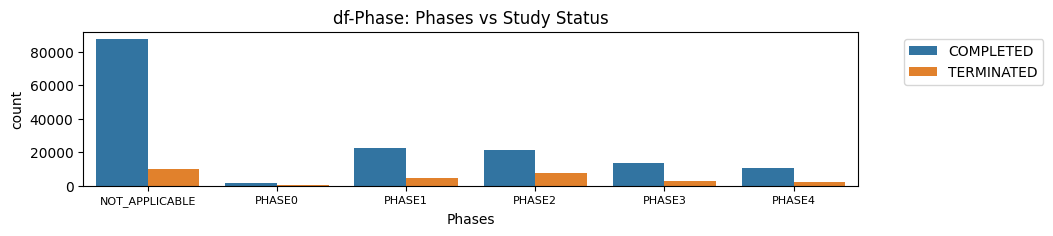

In [9]:
log_fun('Phases', df, '', 'list', False, 0, 'PHASE0')

## Adverse


### Adverse_List

df0-Phase0:
Adverse_List vs Study Status


Adverse_List,Adv_Death,Adv_None,Adv_Other,Adv_Serious
Study Status,,,,
COMPLETED,62,1624,143,56
TERMINATED,13,472,27,9


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2300
Method:                           MLE   Df Model:                            3
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.001949
Time:                        19:07:55   Log-Likelihood:                -1205.4
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                    0.1945
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2487      0.052     23.903      0.000       1.146       1.351
Adv_Death       0.0135      0.343      0.039      0.969      -0.659       0.686
Adv_Other       0.3243      0.245      1.323    

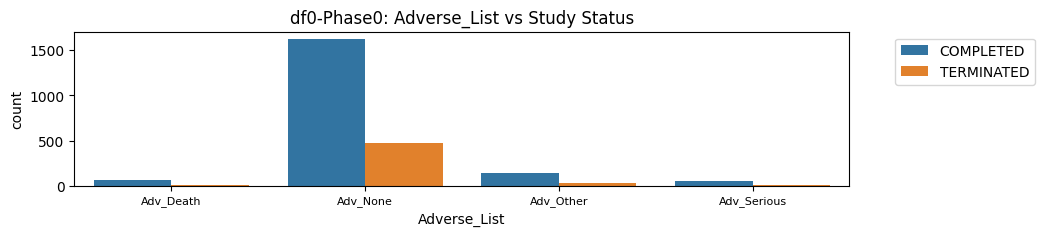

In [10]:
Adverse_List = log_fun("Adverse_List", dfi, i, 'list', False, 0, 'Adv_None')
# Adverse Death has p value >> 0.05 and laso coef ~ 0.0 --> Death does not support adverse from the drug/intervention.
# Corresponds to event noticed in trial but may have to do with patience state of health

### Adverse_Counts
Many unique points, in most of features values, are out of main distribution. --> Make pd.cut
log_fun('Adverse_Counts', dfi, i, 'bin', True, 0) --> Error for small values in some levels


df0-Phase0:
Adverse_Counts vs Study Status


count    2304.000000
mean        0.980469
std         6.281296
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       130.000000
Name: Adverse_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.003199
Time:                        19:07:56   Log-Likelihood:                -1203.9
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                  0.005437
                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

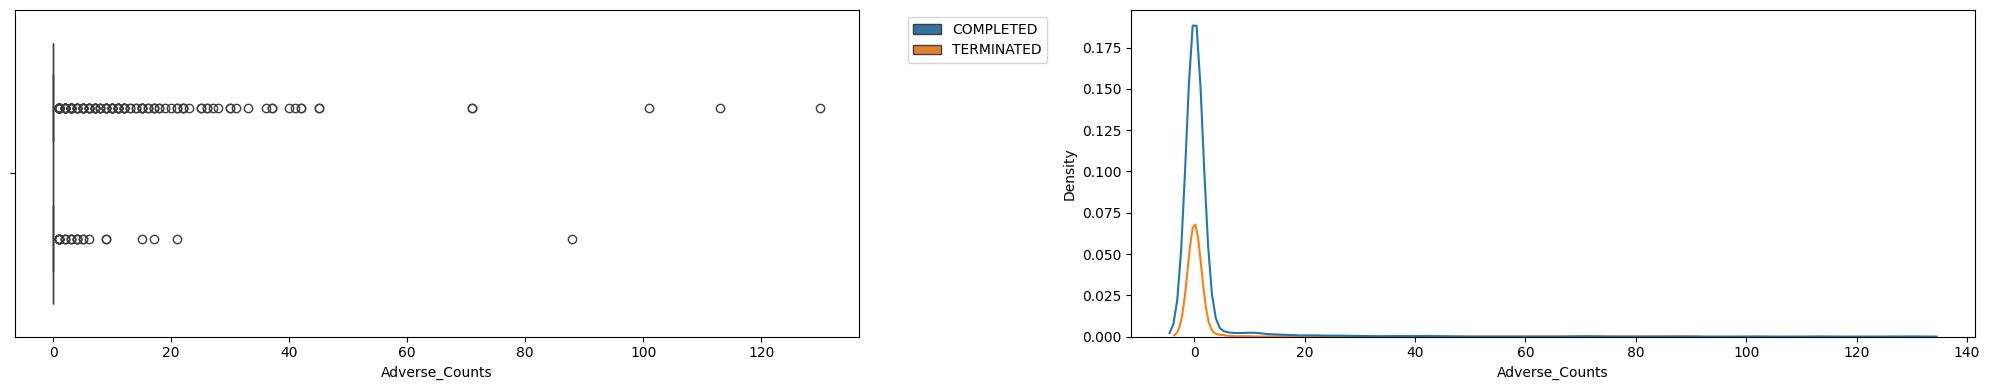

In [11]:
Adverse_Counts = log_fun_cont("Adverse_Counts", dfi, i)  

### Adverse_Counts_Log

df0-Phase0:
Adverse_Counts_Log vs Study Status


count    2304.000000
mean        0.158556
std         0.613821
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.875197
Name: Adverse_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.004468
Time:                        19:07:56   Log-Likelihood:                -1202.4
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                  0.001019
                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------

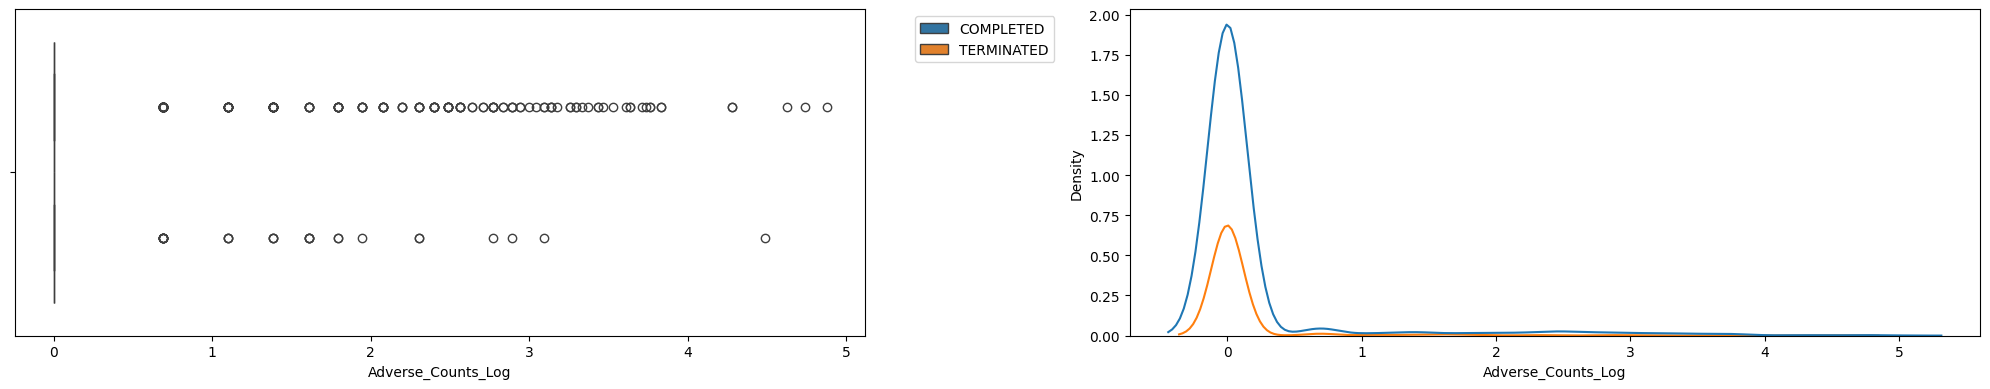

In [12]:
Adverse_Counts_Log = log_fun_cont("Adverse_Counts_Log", dfi, i)

### Adverse_Counts_Sqrt

df0-Phase0:
Adverse_Counts_Sqrt vs Study Status


count    2304.000000
mean        0.231401
std         0.962977
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        11.401754
Name: Adverse_Counts_Sqrt, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.004396
Time:                        19:07:57   Log-Likelihood:                -1202.5
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                  0.001120
                          coef    std err          z      P>|z|      [0.025      0.975]
------------------

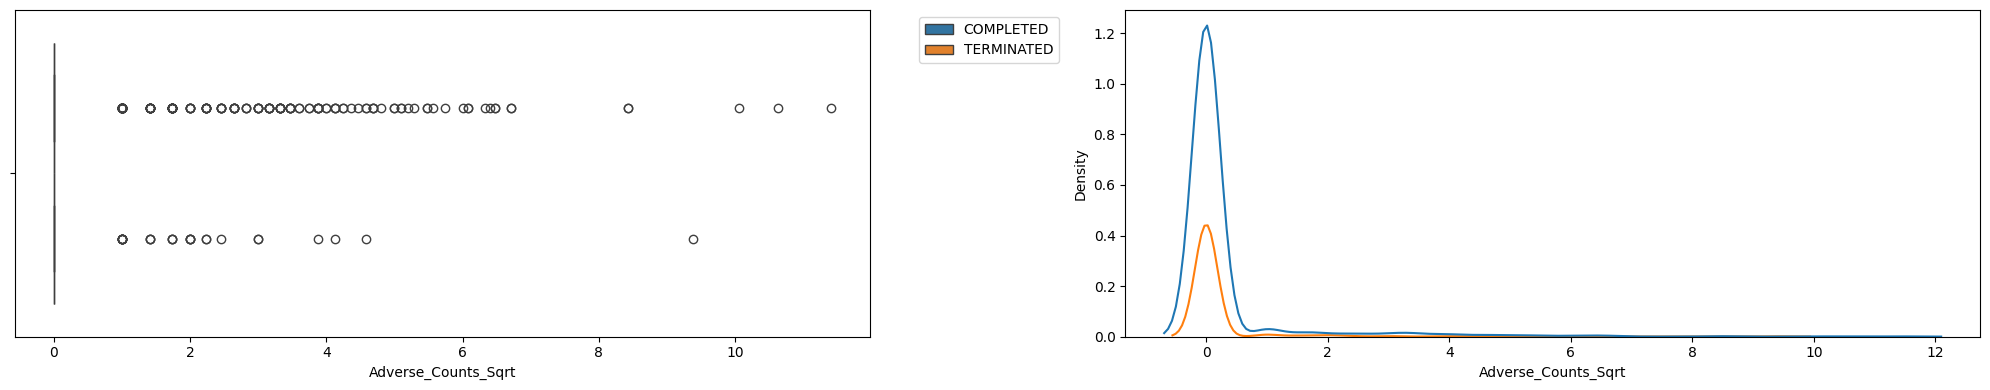

In [13]:
Adverse_Counts_Sqrt = log_fun_cont("Adverse_Counts_Sqrt", dfi, i)

### Adverse_Categ

df0-Phase0:
df0-Phase0: Adverse_Categ vs Study Status


Study Status,COMPLETED,TERMINATED
Adverse_Categ,,
0–1,1680,483
2–130,122,19


df0-Phase0, Adverse_Categ p-value:
0.018144124827528137
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Adverse_Categ vs Study Status


Adverse_Categ,0–1,2–130
Study Status,,
COMPLETED,1680,122
TERMINATED,483,19


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.002797
Time:                        19:07:57   Log-Likelihood:                -1204.4
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                  0.009336
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.2465      0.052     24.144      0.000       1.145       1.348
Adverse_Categ     0.6132      0.252      2.433      0.015       0.119       1.107


df0-Phase0, Adverse_Categ p-values:
[c

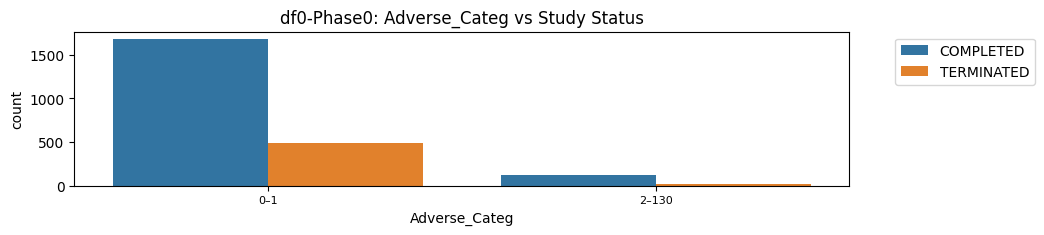

In [14]:
chi2_fun('Adverse_Categ', dfi, i)
#### log_fun
Adverse_Categ = log_fun("Adverse_Categ", dfi, i, 'bin', False, 0)

### Adverse_Bin

df0-Phase0:
df0-Phase0: Adverse_Bin vs Study Status


Study Status,COMPLETED,TERMINATED
Adverse_Bin,,
No,1643,475
Yes,159,27


df0-Phase0, Adverse_Bin p-value:
0.015814548599405644
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Adverse_Bin vs Study Status


Adverse_Bin,No,Yes
Study Status,,
COMPLETED,1643,159
TERMINATED,475,27


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.002834
Time:                        19:07:58   Log-Likelihood:                -1204.4
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                  0.008884
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2409      0.052     23.821      0.000       1.139       1.343
Adverse_Bin     0.5323      0.215      2.481      0.013       0.112       0.953


df0-Phase0, Adverse_Bin p-values:
[const      

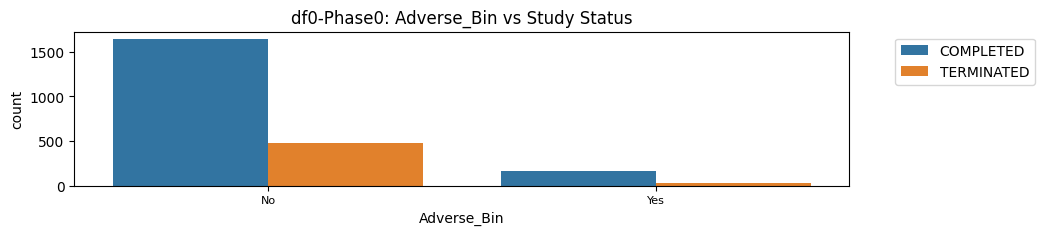

In [15]:
chi2_fun('Adverse_Bin', dfi, i)
#### log_fun
Adverse_Bin = log_fun("Adverse_Bin", dfi, i, 'bin', False, 0)

#### AIC

In [16]:
# Does not include Adverse_Categ as distribution was until 0.75 quantile almost to all dfis = 0. 
Adverse_Counts_aic = fun_compare(i, Adverse_Counts = Adverse_Counts[0], 
                                 Adverse_Counts_Log = Adverse_Counts_Log[0], 
                                 Adverse_Counts_Sqrt = Adverse_Counts_Sqrt[0],
                                 Adverse_Categ = Adverse_Categ[0],
                                 Adverse_Bin = Adverse_Bin[0])

## Adverse_System


### Adverse_System_List


df0-Phase0:
Adverse_System_List vs Study Status


Adverse_System_List,Adv_Sy_Blood/ Lymphatic,Adv_Sy_Cardio,Adv_Sy_Death,Adv_Sy_Ear,Adv_Sy_Endocrine,Adv_Sy_Eye,Adv_Sy_Gastrointestinal,Adv_Sy_General,Adv_Sy_Genetic,Adv_Sy_Hepatobiliary,...,Adv_Sy_None,Adv_Sy_Pregnancy/ Perinatal,Adv_Sy_Psychiatric/ Social,Adv_Sy_Renal/ Urinary,Adv_Sy_Reproductive/ Breast,Adv_Sy_Respiratory,Adv_Sy_Skin,Adv_Sy_Social,Adv_Sy_Surgical/ Medical,Adv_Sy_Vascular
Study Status,,,,,,,,,,,,,,,,,,,,,
COMPLETED,27,37,22,11,10,24,88,72,1,7,...,1624,3,29,30,13,39,54,1,10,28
TERMINATED,8,10,3,2,3,5,15,15,0,1,...,472,0,9,5,2,8,10,0,1,4


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2276
Method:                           MLE   Df Model:                           27
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.01153
Time:                        19:07:58   Log-Likelihood:                -1193.9
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                    0.4192
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    1.2544      0.052     24.118      0.000       1.152       1.356
Adv_Sy_Blood/ Lymphatic                 -0.6170      

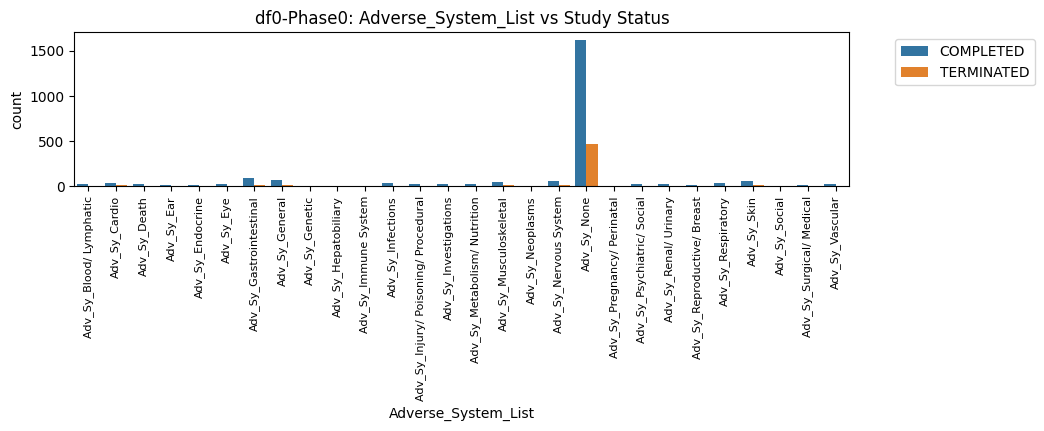

In [17]:
Adverse_System_List = log_fun("Adverse_System_List", dfi, i, 'list', False, 90, 'Adv_Sy_None' )


### Adverse_System_Counts


df0-Phase0:
Adverse_System_Counts vs Study Status


count    2304.000000
mean        0.393229
std         1.869579
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        21.000000
Name: Adverse_System_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:               0.0003157
Time:                        19:07:59   Log-Likelihood:                -1207.4
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                    0.3825
                            coef    std err          z      P>|z|      [0.025      0.975]
------------

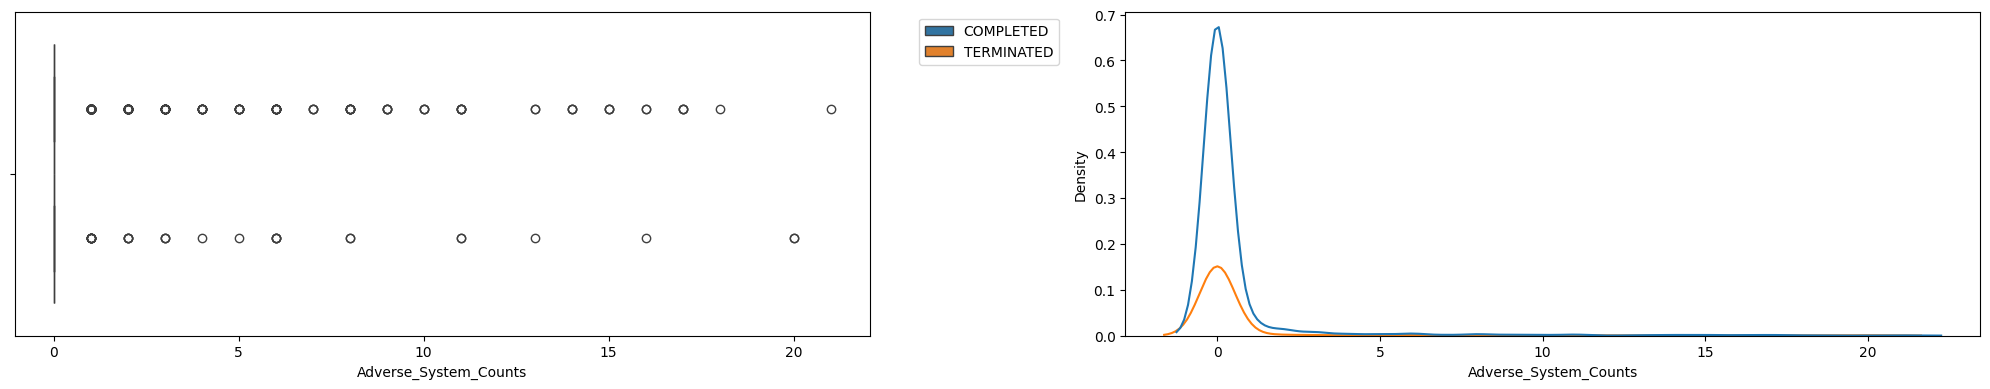

In [18]:
Adverse_System_Counts = log_fun_cont("Adverse_System_Counts", dfi, i)

### Adverse_System_Counts_Log


df0-Phase0:
Adverse_System_Counts_Log vs Study Status


count    2304.000000
mean        0.125292
std         0.453075
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.091042
Name: Adverse_System_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.001425
Time:                        19:07:59   Log-Likelihood:                -1206.1
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                   0.06359
                                coef    std err          z      P>|z|      [0.025      0.975]


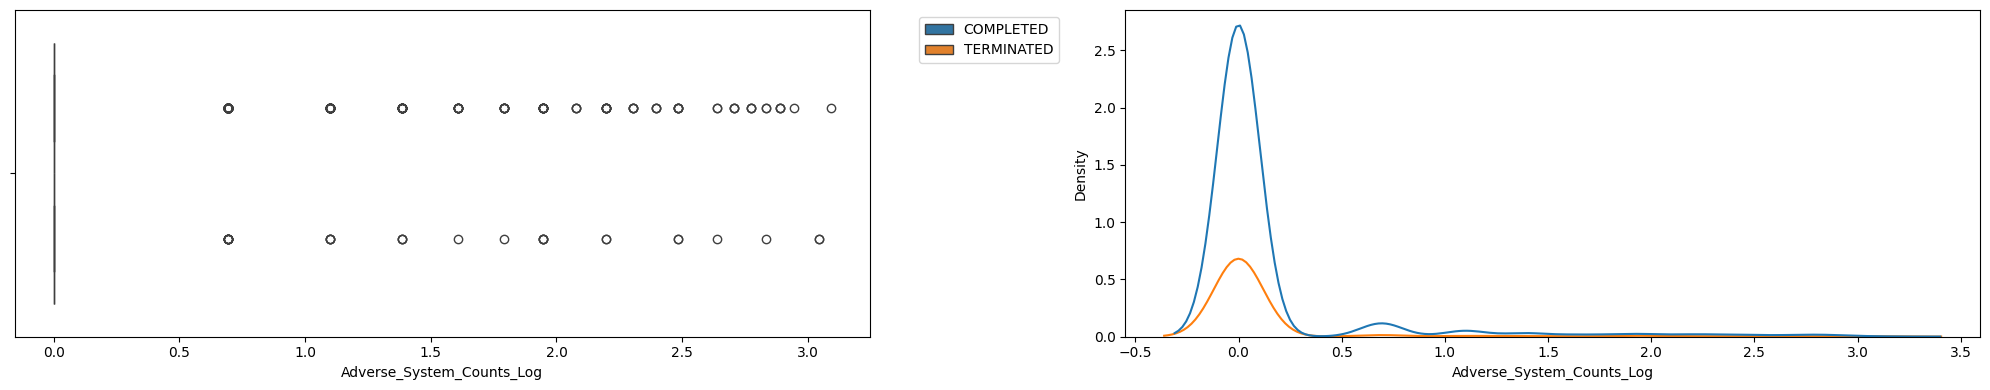

In [19]:
Adverse_System_Counts_Log = log_fun_cont("Adverse_System_Counts_Log", dfi, i)

### Adverse_System_Counts_Sqrt


df0-Phase0:
Adverse_System_Counts_Sqrt vs Study Status


count    2304.000000
mean        0.167014
std         0.604561
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.582576
Name: Adverse_System_Counts_Sqrt, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.001397
Time:                        19:08:00   Log-Likelihood:                -1206.1
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                   0.06623
                                 coef    std err          z      P>|z|      [0.025      0.97

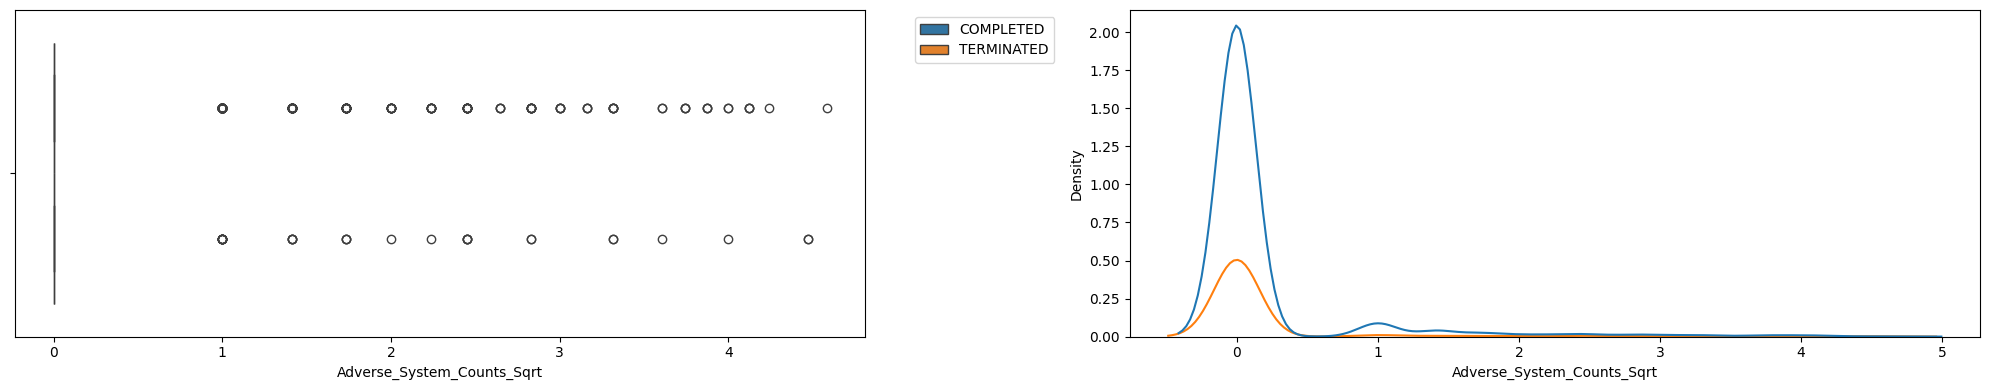

In [20]:
Adverse_System_Counts_Sqrt = log_fun_cont("Adverse_System_Counts_Sqrt", dfi, i)


### Adverse_System_Categ


df0-Phase0:
df0-Phase0: Adverse_System_Categ vs Study Status


Study Status,COMPLETED,TERMINATED
Adverse_System_Categ,,
0–1,1693,481
2–21,109,21


df0-Phase0, Adverse_System_Categ p-value:
0.1355147956743148
No significant difference


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Adverse_System_Categ vs Study Status


Adverse_System_Categ,0–1,2–21
Study Status,,
COMPLETED,1693,109
TERMINATED,481,21


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.001135
Time:                        19:08:00   Log-Likelihood:                -1206.4
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                   0.09773
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.2584      0.052     24.355      0.000       1.157       1.360
Adverse_System_Categ     0.3884      0.244      1.593      0.111      -0.090       0.866


df0-Phase0

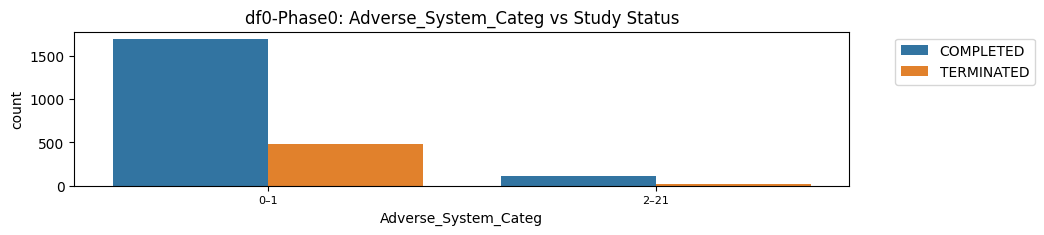

In [21]:
chi2_fun("Adverse_System_Categ", dfi, i)
#### log_fun
Adverse_System_Categ = log_fun('Adverse_System_Categ', dfi, i, 'bin', True, 0)

#### AIC


In [22]:
Adverse_System_Counts_aic = fun_compare(i, Adverse_System_Counts = Adverse_System_Counts[0], 
                                        Adverse_System_Counts_Log = Adverse_System_Counts_Log[0],
                                        Adverse_System_Counts_Sqrt = Adverse_System_Counts_Sqrt[0],
                                        Adverse_System_Categ = Adverse_System_Categ[0])
list(Adverse_System_Counts_aic['AIC_min'].values)

['Adverse_System_Counts_Log']

#### AIC_all

In [23]:
Adverse_aic = fun_compare(i, Adverse_List = Adverse_List[0], Adverse_System_List = Adverse_System_List[0])


## Placebo_Bin

df0-Phase0:
df0-Phase0: Placebo_Bin vs Study Status


Study Status,COMPLETED,TERMINATED
Placebo_Bin,,
No,1377,431
Yes,425,71


df0-Phase0, Placebo_Bin p-value:
7.113185784943173e-06
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Placebo_Bin vs Study Status


Placebo_Bin,No,Yes
Study Status,,
COMPLETED,1377,425
TERMINATED,431,71


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.009225
Time:                        19:08:01   Log-Likelihood:                -1196.6
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                 2.351e-06
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1616      0.055     21.045      0.000       1.053       1.270
Placebo_Bin     0.6278      0.140      4.498      0.000       0.354       0.901


df0-Phase0, Placebo_Bin p-values:
[const      

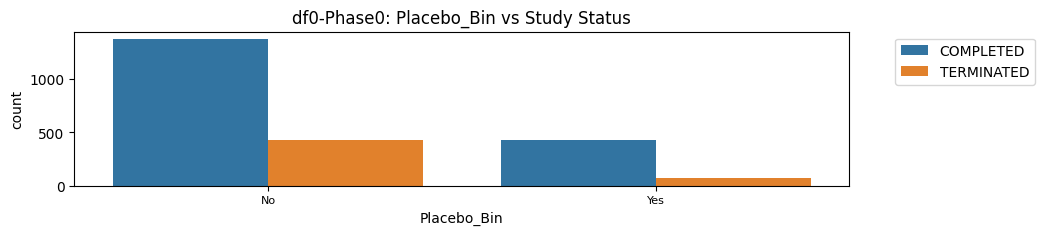

In [24]:
chi2_fun("Placebo_Bin", dfi, i)
### log_fun
Placebo_Bin = log_fun('Placebo_Bin', dfi, i, 'bin', False, 0)

## Standard_Care_Bin 

df0-Phase0:
df0-Phase0: Standard_Care_Bin vs Study Status


Study Status,COMPLETED,TERMINATED
Standard_Care_Bin,,
No,1725,466
Yes,77,36


df0-Phase0, Standard_Care_Bin p-value:
0.011010750667975239
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Standard_Care_Bin vs Study Status


Standard_Care_Bin,No,Yes
Study Status,,
COMPLETED,1725,77
TERMINATED,466,36


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.002682
Time:                        19:08:01   Log-Likelihood:                -1204.6
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                   0.01092
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.3088      0.052     25.069      0.000       1.206       1.411
Standard_Care_Bin    -0.5485      0.209     -2.630      0.009      -0.957      -0.140


df0-Phase0, Standard_C

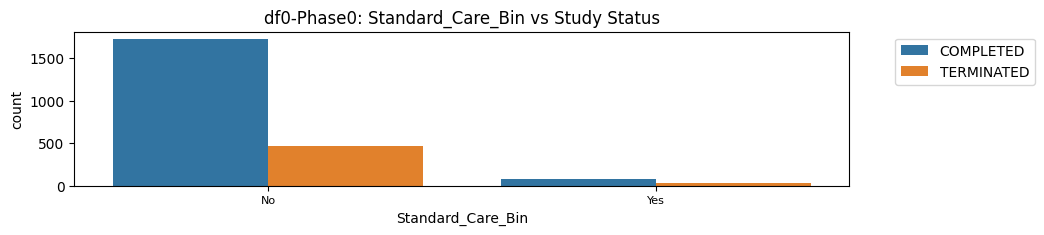

In [25]:
chi2_fun("Standard_Care_Bin", dfi, i)
### log_fun
Standard_Care_Bin = log_fun('Standard_Care_Bin', dfi, i, 'bin', False, 0)

## Healthy_Bin

df0-Phase0:
df0-Phase0: Healthy_Bin vs Study Status


Study Status,COMPLETED,TERMINATED
Healthy_Bin,,
No,998,379
Yes,804,123


df0-Phase0, Healthy_Bin p-value:
6.660750238111554e-16
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Healthy_Bin vs Study Status


Healthy_Bin,No,Yes
Study Status,,
COMPLETED,998,804
TERMINATED,379,123


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.02871
Time:                        19:08:01   Log-Likelihood:                -1173.1
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                 8.191e-17
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9682      0.060     16.047      0.000       0.850       1.086
Healthy_Bin     0.9092      0.114      7.970      0.000       0.686       1.133


df0-Phase0, Healthy_Bin p-values:
[const      

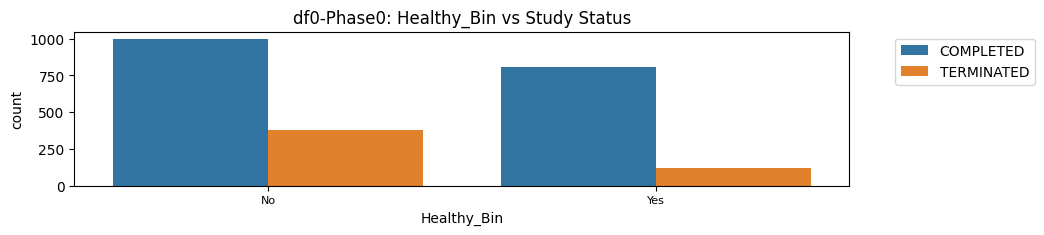

In [26]:
chi2_fun("Healthy_Bin", dfi, i)
### log_fun
Healthy_Bin = log_fun('Healthy_Bin', dfi, i, 'bin', False, 0)

## Covid_19_Bin

df0-Phase0:
df0-Phase0: Covid_19_Bin vs Study Status


Study Status,COMPLETED,TERMINATED
Covid_19_Bin,,
No,1790,494
Yes,12,8


df0-Phase0, Covid_19_Bin p-value:
0.08734496844748144
No significant difference


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Covid_19_Bin vs Study Status


Covid_19_Bin,No,Yes
Study Status,,
COMPLETED,1790,12
TERMINATED,494,8


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.001404
Time:                        19:08:02   Log-Likelihood:                -1206.1
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                   0.06549
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.2874      0.051     25.332      0.000       1.188       1.387
Covid_19_Bin    -0.8823      0.459     -1.921      0.055      -1.782       0.018


df0-Phase0, Covid_19_Bin p-values:
[const 

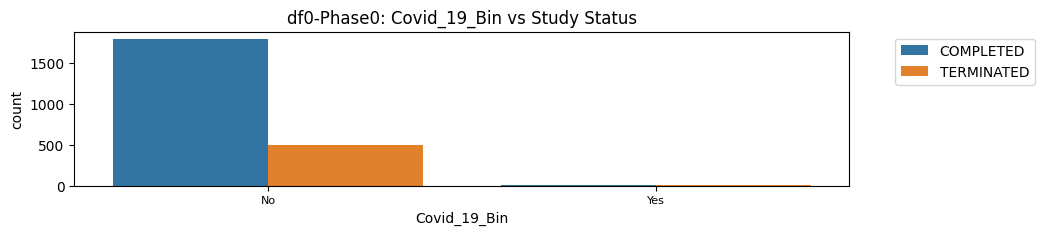

In [27]:
chi2_fun("Covid_19_Bin", dfi, i)
### log_fun
Covid_19_Bin = log_fun('Covid_19_Bin', dfi, i, 'bin', False, 0)

## Conditions

### Conditions_List
- Conditions_List col. has almost all data points to Disease category. (see df['Conditions_List'] value counts), while Conditions_Spec_List gives same information with more categories and evenly sparsed data.


df0-Phase0:
Conditions_List vs Study Status


Conditions_List,Cond_Diseases,Cond_Health Care,Cond_Other,"Cond_Phenomena, Processes","Cond_Psychiatry, Psychology, Anthropology, Sociology","Cond_Therapeutic, Diagnostic, Equipment"
Study Status,,,,,,
COMPLETED,1513,3,194,159,333,28
TERMINATED,460,4,22,35,85,8


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2298
Method:                           MLE   Df Model:                            5
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.01203
Time:                        19:08:02   Log-Likelihood:                -1193.3
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                 2.254e-05
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    1.9635      0.174     11.314      0.000       1.623       2.304
Cond_

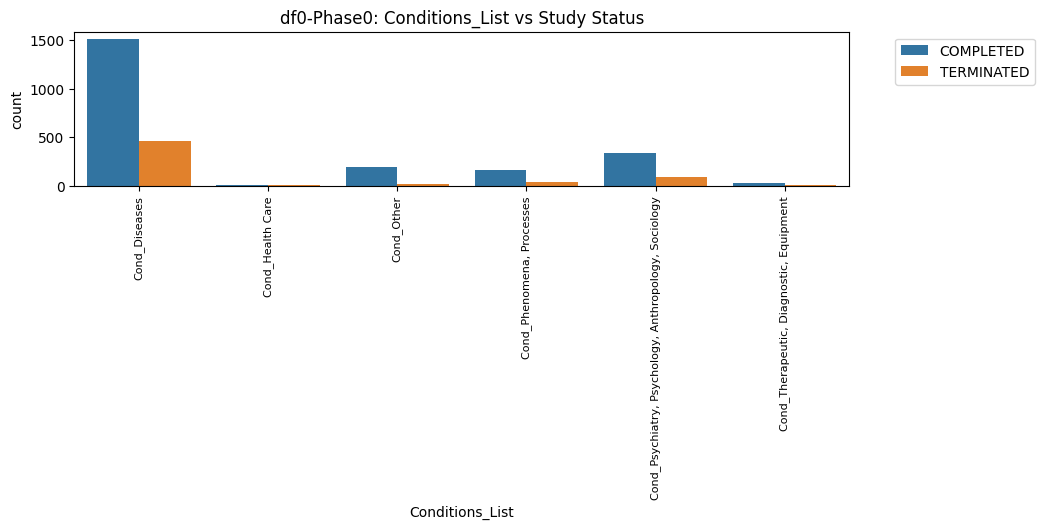

In [28]:
Conditions_List = log_fun("Conditions_List", dfi, i, 'list', False, 90, 'Cond_Other')

### Conditions_Spec_List

df0-Phase0:
Conditions_Spec_List vs Study Status


Conditions_Spec_List,Bacterial Infections and Mycoses,Cardiovascular,Chemical Disorders,Cond_Spec_Other,"Digestive System, Nutritional, Metabolic",Endocrine System,Eye,Health Care,"Hemic, Lymphatic, Immune System","Hereditary, Neonatal, Abnormalities",...,Otorhinolaryngologic,"Pathological Conditions, Signs, Symptoms","Psychiatry, Psychology, Anthropology, Sociology","Respiratory, Circulatory","Skin, Tissue",Stomatognathic,"Therapeutics, Diagnosis, Equipment","Urogenital, Pregnancy",Virus Diseases,"Wounds, Injuries"
Study Status,,,,,,,,,,,,,,,,,,,,,
COMPLETED,106,145,79,194,277,108,43,3,159,58,...,22,58,360,123,197,60,31,181,50,65
TERMINATED,31,51,20,22,73,30,12,4,62,30,...,13,15,86,46,68,9,8,58,14,22


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2281
Method:                           MLE   Df Model:                           22
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.05111
Time:                        19:08:02   Log-Likelihood:                -1146.1
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                 4.076e-16
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                               1.8968      0.115     16.487      0.000       1.671       2.122
Bacterial Infections

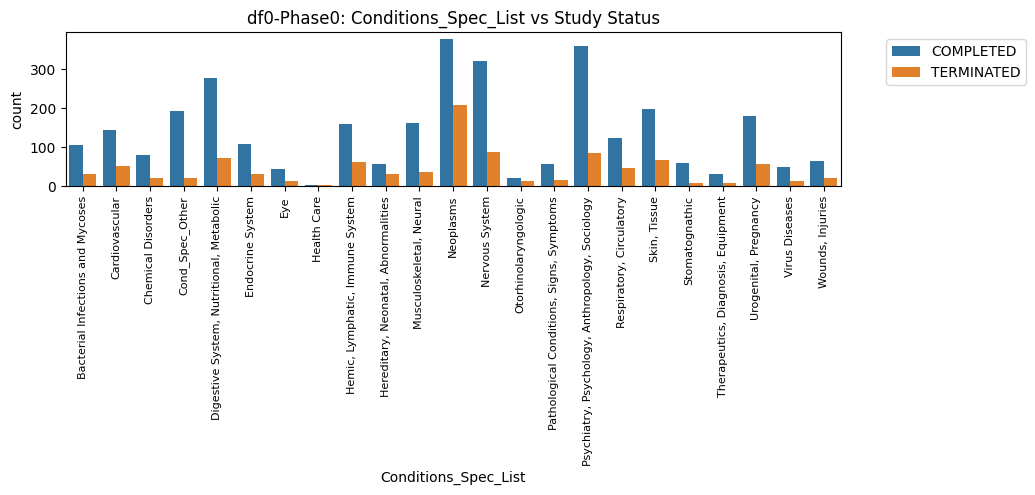

In [29]:
Conditions_Spec_List = log_fun("Conditions_Spec_List", dfi, i, 'list', False, 90, 'Cond_Spec_Other' )

#### AIC 
- Conditions_List and Conditions_Spec_List give similar information. 
- Conditions_List excluded. 
- Conditions_Spec_list is mmore spesific level of Condition_List column and thus, will just slowen the algorythms later
- Conditions_List col. has almost all data points to Disease category. (see df['Conditions_List'] value counts), while Conditions_Spec_List gives same information with more categories and evenly sparsed data.
- However more categories in Cond_Spec col --> lasso in Models file will exclude unessecary ones

#### AIC_all

In [30]:
Conditions_aic = fun_compare(i, Conditions_List = Conditions_List[0], 
                             Conditions_Spec_List = Conditions_Spec_List[0])

### Covid_19_Bin

df0-Phase0:
df0-Phase0: Covid_19_Bin vs Study Status


Study Status,COMPLETED,TERMINATED
Covid_19_Bin,,
No,1790,494
Yes,12,8


df0-Phase0, Covid_19_Bin p-value:
0.08734496844748144
No significant difference


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Covid_19_Bin vs Study Status


Covid_19_Bin,No,Yes
Study Status,,
COMPLETED,1790,12
TERMINATED,494,8


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.001404
Time:                        19:08:03   Log-Likelihood:                -1206.1
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                   0.06549
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.2874      0.051     25.332      0.000       1.188       1.387
Covid_19_Bin    -0.8823      0.459     -1.921      0.055      -1.782       0.018


df0-Phase0, Covid_19_Bin p-values:
[const 

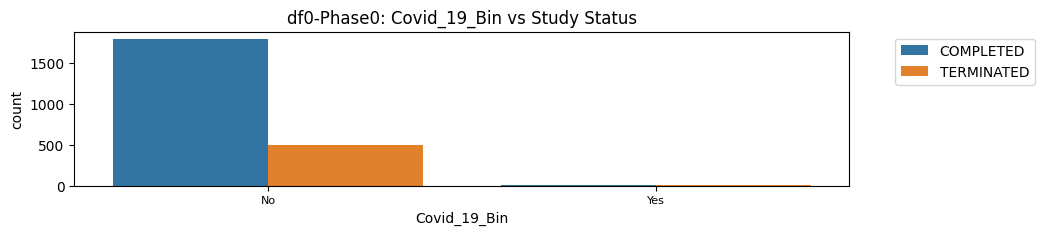

In [31]:
chi2_fun("Covid_19_Bin", dfi, i)
### log_fun
Covid_19_Bin = log_fun('Covid_19_Bin', dfi, i, 'Bin', False, 0)

## Funder_Type_Dum

df0-Phase0:
Funder_Type_Dum vs Study Status


Funder_Type_Dum,FUNDER_OTHER,GOVERM,INDUSTRY
Study Status,,,
COMPLETED,1554,73,175
TERMINATED,446,20,36


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2301
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.001342
Time:                        19:08:03   Log-Likelihood:                -1206.2
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                    0.1978
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2483      0.054     23.237      0.000       1.143       1.354
GOVERM         0.0464      0.258      0.180      0.857      -0.459       0.552
INDUSTRY       0.3329      0.191      1.746      0.0

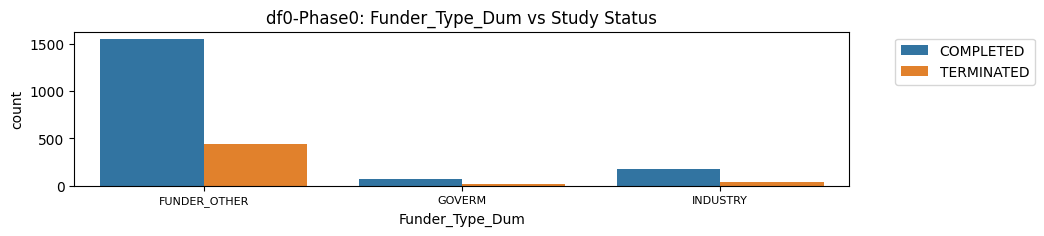

In [32]:
Funder_Type_Dum = log_fun("Funder_Type_Dum", dfi, i, 'list', False, 0, 'FUNDER_OTHER')

### Sponsor_Collab_List

df0-Phase0:
Sponsor_Collab_List vs Study Status


Sponsor_Collab_List,Hospital,Pharmaceutical,Spon_coll_Other,University
Study Status,,,,
COMPLETED,393,601,183,1230
TERMINATED,114,189,61,337


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2300
Method:                           MLE   Df Model:                            3
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.001374
Time:                        19:08:04   Log-Likelihood:                -1206.1
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                    0.3451
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.3424      0.109     12.272      0.000       1.128       1.557
Hospital          -0.0388      0.123     -0.316      0.752      -0.279       0.202
Pharmaceutical    -0.1840      0.106

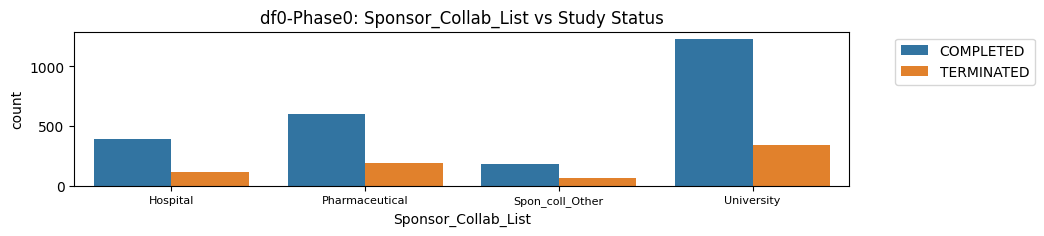

In [33]:
Sponsor_Collab_List = log_fun("Sponsor_Collab_List", dfi, i, 'list', False, 0, 'Spon_coll_Other')

## Age_List

df0-Phase0:
Age_List vs Study Status


Age_List,ADULT,CHILD,OLDER_ADULT
Study Status,,,
COMPLETED,1705,240,1169
TERMINATED,481,51,398


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2301
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.01649
Time:                        19:08:04   Log-Likelihood:                -1187.9
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                 2.246e-09
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.7372      0.246      7.058      0.000       1.255       2.220
ADULT           0.0788      0.255      0.309      0.757      -0.421       0.578
OLDER_ADULT    -0.7370      0.124     -5.950    

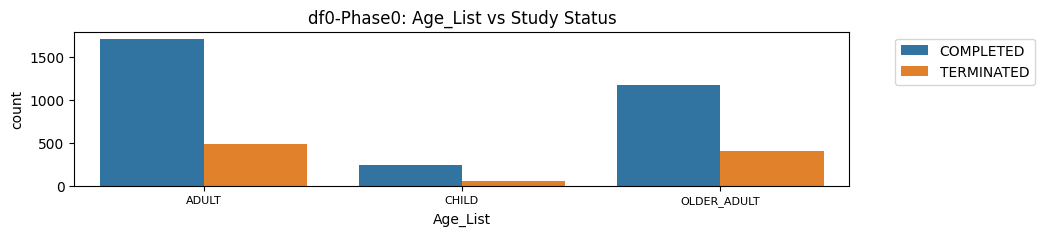

In [34]:
Age_List = log_fun("Age_List", dfi, i, 'list', False, 0, 'CHILD')

## Sex_Dum


df0-Phase0:
Sex_Dum vs Study Status


Sex_Dum,ALL,FEMALE,MALE
Study Status,,,
COMPLETED,1468,199,134
TERMINATED,428,50,24


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2303
Model:                          Logit   Df Residuals:                     2300
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.002280
Time:                        19:08:04   Log-Likelihood:                -1204.8
converged:                       True   LL-Null:                       -1207.5
Covariance Type:            nonrobust   LLR p-value:                   0.06372
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2325      0.055     22.437      0.000       1.125       1.340
FEMALE         0.1488      0.167      0.888      0.374      -0.179       0.477
MALE           0.4873      0.228      2.134      0.0

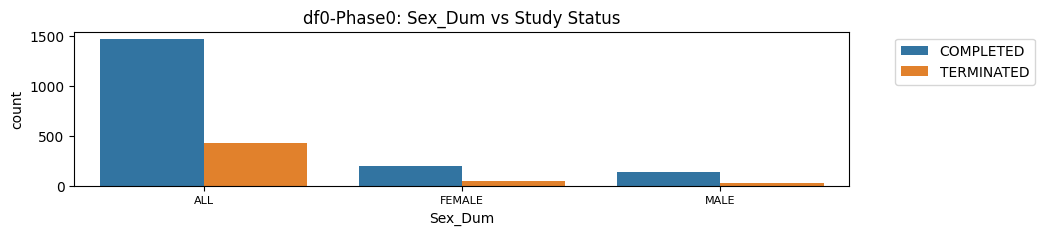

In [35]:
Sex_Dum = log_fun("Sex_Dum", dfi, i, 'list', False, 0, 'ALL')

## Study Design

### Allocation_Dum

df0-Phase0:
Allocation_Dum vs Study Status


Allocation_Dum,NON_RANDOMIZED,NOT_APPLICABLE,RANDOMIZED
Study Status,,,
COMPLETED,213,642,939
TERMINATED,71,254,176


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2295
Model:                          Logit   Df Residuals:                     2292
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.02006
Time:                        19:08:04   Log-Likelihood:                -1180.1
converged:                       True   LL-Null:                       -1204.3
Covariance Type:            nonrobust   LLR p-value:                 3.229e-11
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.9272      0.074     12.509      0.000       0.782       1.072
NON_RANDOMIZED     0.1714      0.156      1.100      0.271      -0.134       0.477
RANDOMIZED         0.7471      0.111

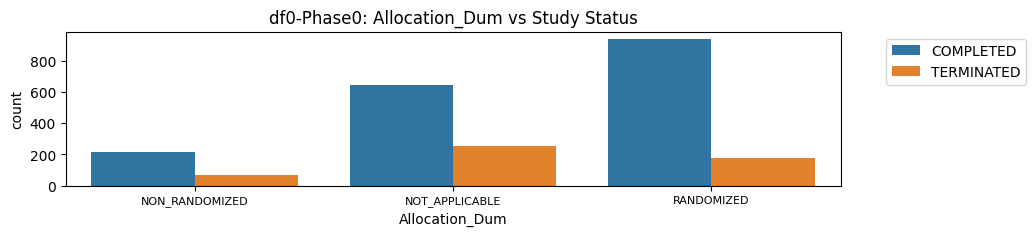

In [36]:
Allocation_Dum = log_fun("Allocation_Dum", dfi, i, 'list', False, 0, 'NOT_APPLICABLE')

### Masking_Dum


df0-Phase0:
Masking_Dum vs Study Status


Masking_Dum,DOUBLE,MASK_NONE,QUADRUPLE,SINGLE,TRIPLE
Study Status,,,,,
COMPLETED,224,1046,167,214,147
TERMINATED,37,382,32,31,19


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2299
Model:                          Logit   Df Residuals:                     2294
Method:                           MLE   Df Model:                            4
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.02454
Time:                        19:08:05   Log-Likelihood:                -1175.7
converged:                       True   LL-Null:                       -1205.3
Covariance Type:            nonrobust   LLR p-value:                 4.363e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0073      0.060     16.850      0.000       0.890       1.124
DOUBLE         0.7935      0.187      4.237      0.000       0.426       1.160
QUADRUPLE      0.6450      0.202      3.193      0.0

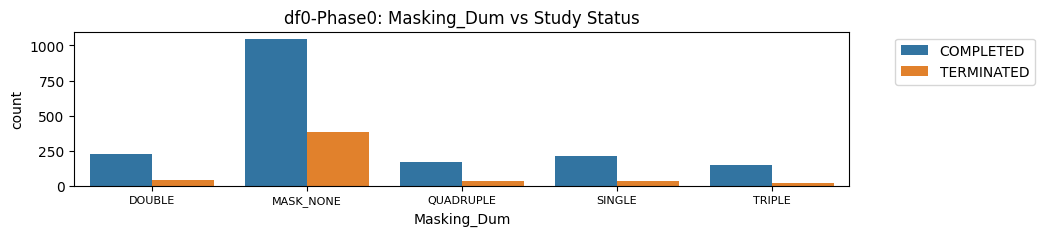

In [37]:
Masking_Dum = log_fun("Masking_Dum", dfi, i, 'list', False, 0, 'MASK_NONE')

### Masking_Detail_List

df0-Phase0:
Masking_Detail_List vs Study Status


Masking_Detail_List,CARE_PROVIDER,INVESTIGATOR,MASK_DET_NONE,OUTCOMES_ASSESSOR,PARTICIPANT
Study Status,,,,,
COMPLETED,287,459,1046,381,640
TERMINATED,48,80,382,56,104


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2296
Model:                          Logit   Df Residuals:                     2291
Method:                           MLE   Df Model:                            4
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.01992
Time:                        19:08:05   Log-Likelihood:                -1179.3
converged:                       True   LL-Null:                       -1203.3
Covariance Type:            nonrobust   LLR p-value:                 9.767e-10
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.0516      0.059     17.838      0.000       0.936       1.167
CARE_PROVIDER        -0.1668      0.223     -0.750      0.454      -0.603       0.269
INVESTIGATOR          0.

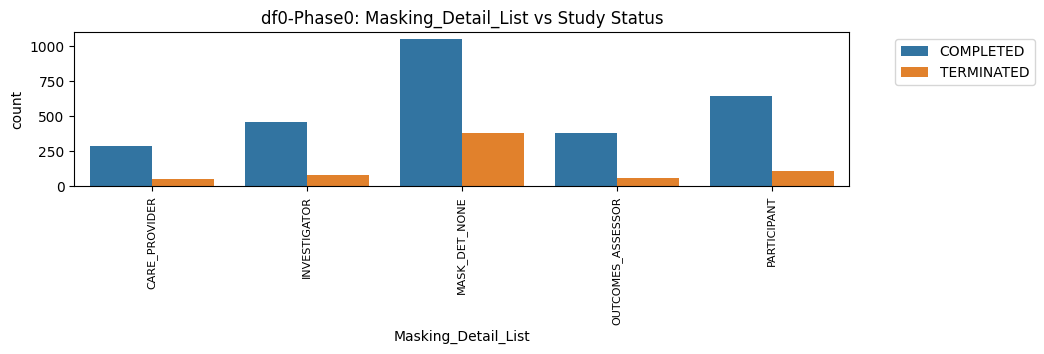

In [38]:
Masking_Detail_List = log_fun("Masking_Detail_List", dfi, i, 'list', False, 90, 'MASK_DET_NONE')


#### AIC_all

In [39]:
Masking_aic = fun_compare(i, Masking_Dum = Masking_Dum[0], 
                             Masking_Detail_List = Masking_Detail_List[0])

### Primary_Purpose_Dum


df0-Phase0:
Primary_Purpose_Dum vs Study Status


Primary_Purpose_Dum,BASIC_SCIENCE,DEVICE_FEASIBILITY,DIAGNOSTIC,HEALTH_SERVICES_RESEARCH,PREVENTION,PRIM_PURP_OTHER,SCREENING,SUPPORTIVE_CARE,TREATMENT
Study Status,,,,,,,,,
COMPLETED,368,20,145,33,153,150,23,88,794
TERMINATED,66,6,55,11,26,34,4,19,277


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2272
Model:                          Logit   Df Residuals:                     2263
Method:                           MLE   Df Model:                            8
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.01470
Time:                        19:08:05   Log-Likelihood:                -1177.2
converged:                       True   LL-Null:                       -1194.8
Covariance Type:            nonrobust   LLR p-value:                 2.545e-05
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.4839      0.190      7.813      0.000       1.112       1.856
BASIC_SCIENCE                0.2344      0.232      1.009      0.313      -0.221       0.

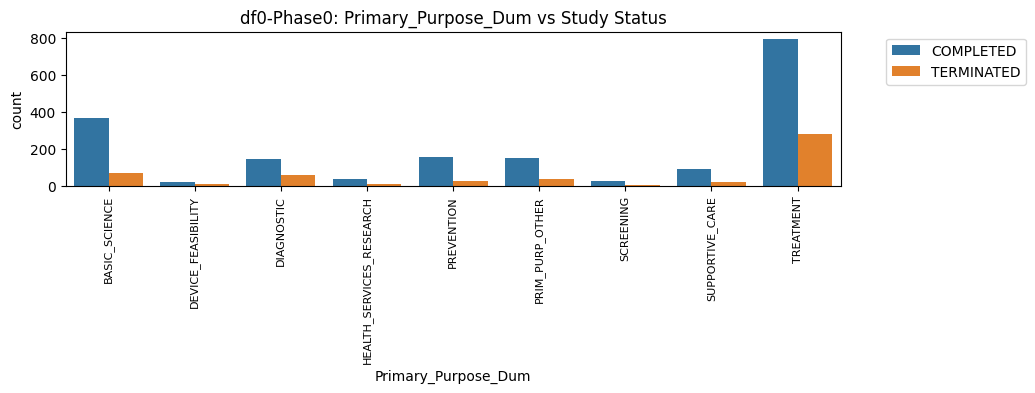

In [40]:
Primary_Purpose_Dum = log_fun("Primary_Purpose_Dum", dfi, i, 'list', False, 90, 'PRIM_PURP_OTHER')

## Arms

### Arm_Counts

df0-Phase0:
Arm_Counts vs Study Status


count    2281.000000
mean        1.935116
std         1.409927
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        40.000000
Name: Arm_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2281
Model:                          Logit   Df Residuals:                     2279
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.01483
Time:                        19:08:06   Log-Likelihood:                -1173.0
converged:                       True   LL-Null:                       -1190.6
Covariance Type:            nonrobust   LLR p-value:                 2.792e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

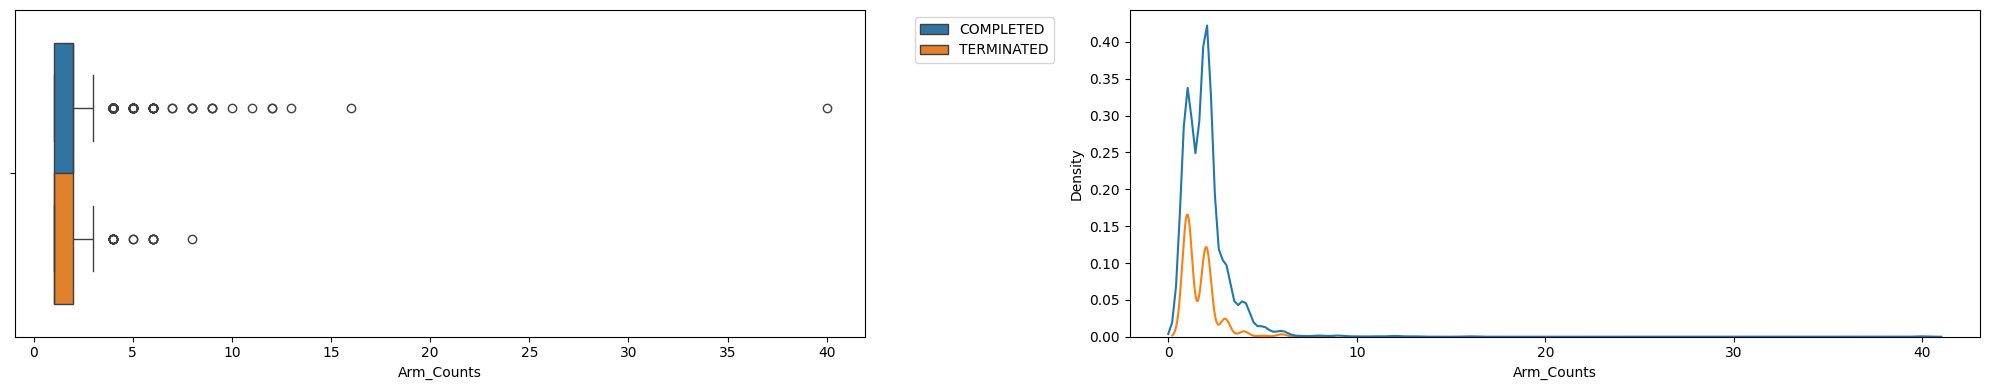

In [41]:
Arm_Counts = Arm_Counts = log_fun_cont("Arm_Counts", dfi, i)

### Arm_Counts_Log

df0-Phase0:
Arm_Counts vs Study Status


count    2281.000000
mean        1.935116
std         1.409927
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        40.000000
Name: Arm_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2281
Model:                          Logit   Df Residuals:                     2279
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.01483
Time:                        19:08:06   Log-Likelihood:                -1173.0
converged:                       True   LL-Null:                       -1190.6
Covariance Type:            nonrobust   LLR p-value:                 2.792e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

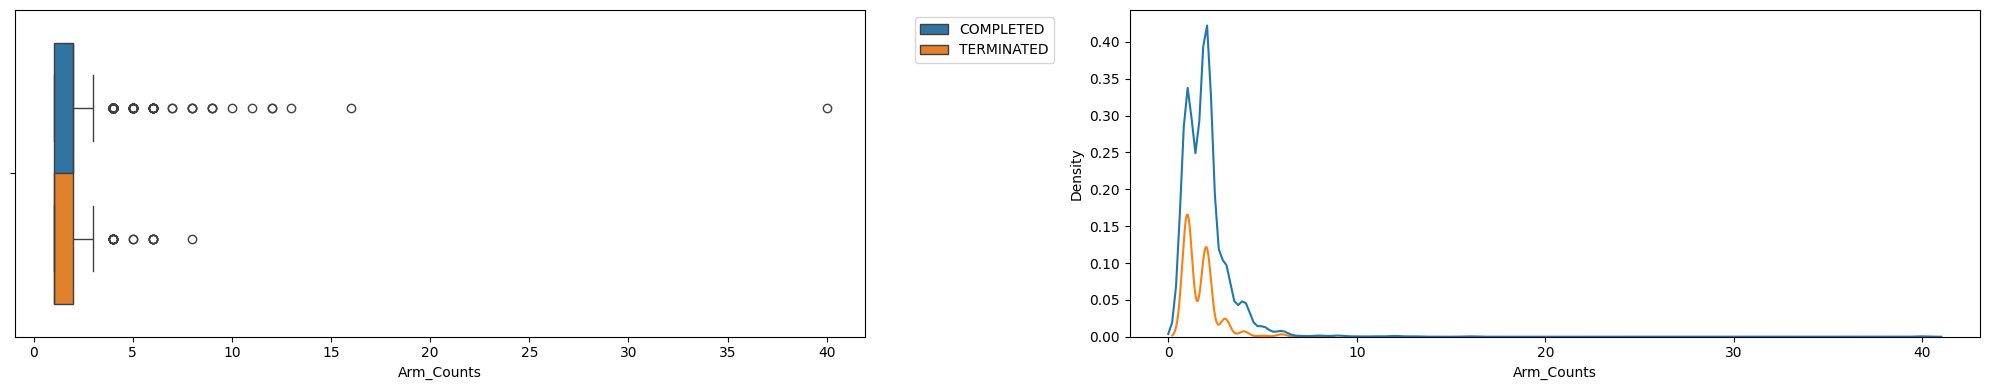

In [42]:
Arm_Counts_Log = Arm_Counts_Log = log_fun_cont("Arm_Counts", dfi, i)

### Arm_Counts_Sqrt

df0-Phase0:
Arm_Counts vs Study Status


count    2281.000000
mean        1.935116
std         1.409927
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        40.000000
Name: Arm_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2281
Model:                          Logit   Df Residuals:                     2279
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.01483
Time:                        19:08:07   Log-Likelihood:                -1173.0
converged:                       True   LL-Null:                       -1190.6
Covariance Type:            nonrobust   LLR p-value:                 2.792e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

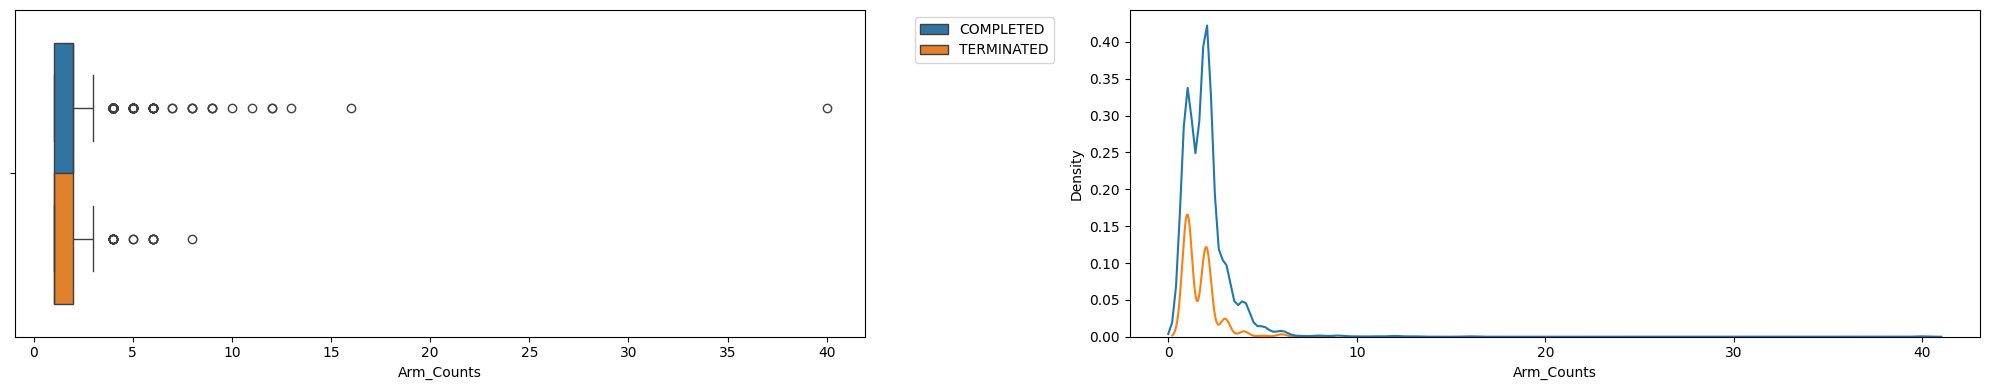

In [43]:
Arm_Counts_Sqrt = Arm_Counts_Sqrt = log_fun_cont("Arm_Counts", dfi, i)

### Arm_Categ

df0-Phase0:
df0-Phase0: Arm_Categ vs Study Status


Study Status,COMPLETED,TERMINATED
Arm_Categ,,
1–2,1456,437
3–40,332,56


df0-Phase0, Arm_Categ p-value:
0.00021201172290272633
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Arm_Categ vs Study Status


Arm_Categ,1–2,3–40
Study Status,,
COMPLETED,1456,332
TERMINATED,437,56


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2281
Model:                          Logit   Df Residuals:                     2279
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.006448
Time:                        19:08:07   Log-Likelihood:                -1182.9
converged:                       True   LL-Null:                       -1190.6
Covariance Type:            nonrobust   LLR p-value:                 8.914e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2035      0.055     22.065      0.000       1.097       1.310
Arm_Categ      0.5763      0.154      3.732      0.000       0.274       0.879


df0-Phase0, Arm_Categ p-values:
[const        6.92

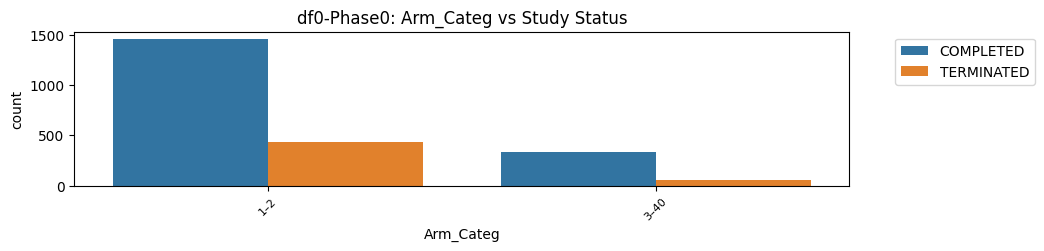

In [44]:
chi2_fun('Arm_Categ', dfi, i)
#### Log_Fun
Arm_Categ = log_fun('Arm_Categ', dfi, i, 'bin', True, 45)

#### AIC

In [45]:
Arm_Counts_aic = fun_compare(i, Arm_Counts = Arm_Counts[0], Arm_Categ = Arm_Categ[0])

## Interventions

### Intervention_Model_Dum


df0-Phase0:
Intervention_Model_Dum vs Study Status


Intervention_Model_Dum,CROSSOVER,FACTORIAL,PARALLEL,SEQUENTIAL,SINGLE_GROUP
Study Status,,,,,
COMPLETED,272,17,750,43,720
TERMINATED,31,5,172,16,278


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2299
Method:                           MLE   Df Model:                            4
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.02271
Time:                        19:08:08   Log-Likelihood:                -1180.4
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                 3.462e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9516      0.071     13.476      0.000       0.813       1.090
CROSSOVER      1.2204      0.202      6.033      0.000       0.824       1.617
FACTORIAL      0.2718      0.514      0.529      0.5

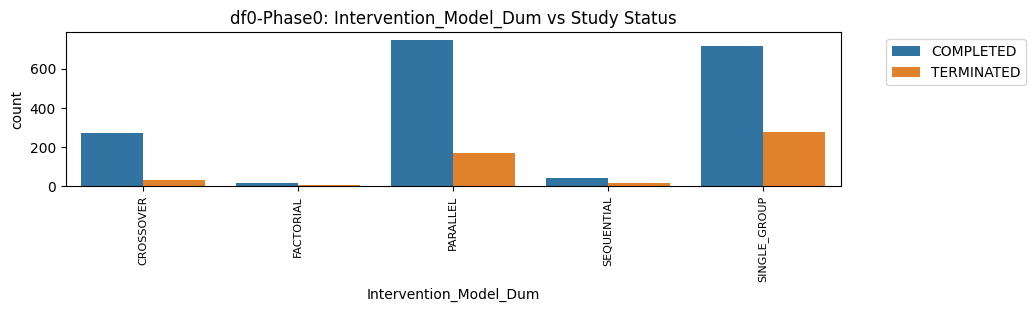

In [46]:
Intervention_Model_Dum = log_fun("Intervention_Model_Dum", dfi, i, 'list', False, 90, 'SINGLE_GROUP' )

### Intervention_Type_List


df0-Phase0:
Intervention_Type_List vs Study Status


Intervention_Type_List,BEHAVIORAL,BIOLOGICAL,COMBINATION_PRODUCT,DEVICE,DIAGNOSTIC_TEST,DIETARY_SUPPLEMENT,DRUG,GENETIC,INTERV_OTHER,PROCEDURE,RADIATION
Study Status,,,,,,,,,,,
COMPLETED,96,122,33,157,17,89,1077,4,295,109,32
TERMINATED,10,51,5,42,10,10,338,1,68,43,21


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2293
Method:                           MLE   Df Model:                           10
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.02098
Time:                        19:08:08   Log-Likelihood:                -1182.5
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                 2.002e-07
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.5613      0.112     13.933      0.000       1.342       1.781
BEHAVIORAL              0.8209      0.341      2.407      0.016       0.152       1.489
BIOLOGICAL      

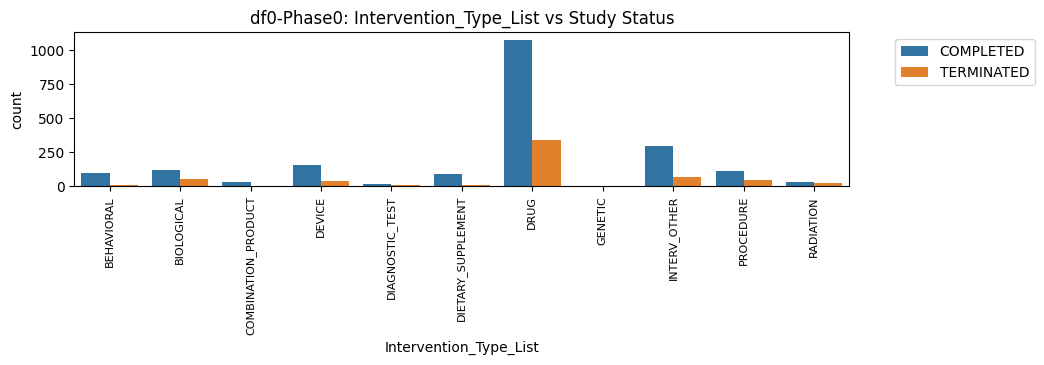

In [47]:
Intervention_Type_List = log_fun("Intervention_Type_List", dfi, i, 'list', False, 90, 'INTERV_OTHER')

### Intervention_Type_Counts


df0-Phase0:
Intervention_Type_Counts vs Study Status


count    2304.000000
mean        1.141493
std         0.398583
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: Intervention_Type_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.004142
Time:                        19:08:08   Log-Likelihood:                -1202.8
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                  0.001561
                               coef    std err          z      P>|z|      [0.025      0.975]
---

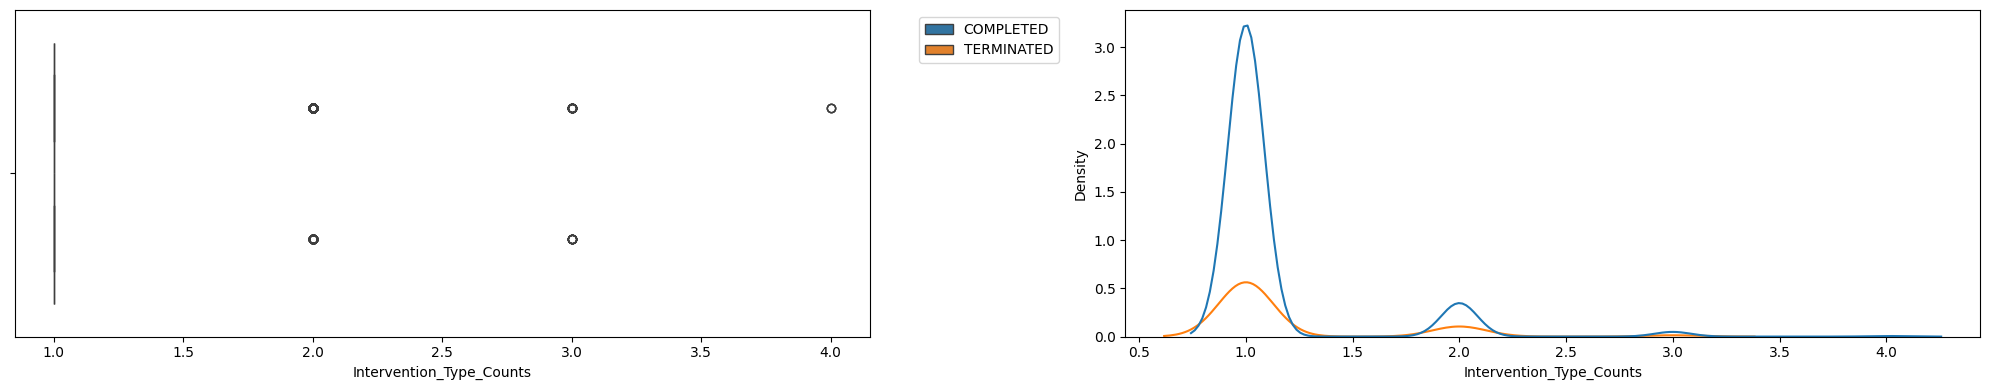

In [48]:
Intervention_Type_Counts = log_fun_cont("Intervention_Type_Counts", dfi, i)

### Intervention_Type_Categ

df0-Phase0:
df0-Phase0: Intervention_Type_Categ vs Study Status


Study Status,COMPLETED,TERMINATED
Intervention_Type_Categ,,
1,1603,415
2–4,199,87


df0-Phase0, Intervention_Type_Categ p-value:
0.00021409173802162506
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Intervention_Type_Categ vs Study Status


Intervention_Type_Categ,1,2–4
Study Status,,
COMPLETED,1603,199
TERMINATED,415,87


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.005515
Time:                        19:08:09   Log-Likelihood:                -1201.1
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                 0.0002622
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.3514      0.055     24.536      0.000       1.243       1.459
Intervention_Type_Categ    -0.5240      0.140     -3.747      0.000      -0.798      -0.250


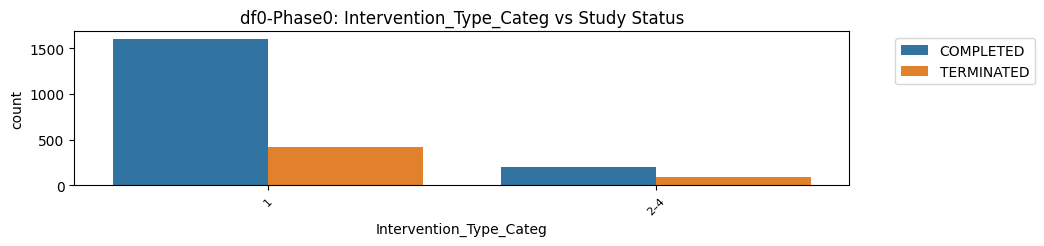

In [49]:
chi2_fun('Intervention_Type_Categ', dfi, i)
#### log_fun
Intervention_Type_Categ = log_fun('Intervention_Type_Categ', dfi, i, 'bin', True, 45)

#### AIC

In [50]:
Intervention_Type_Counts_aic = fun_compare(i, Intervention_Type_Counts = Intervention_Type_Counts[0], Intervention_Type_Categ = Intervention_Type_Categ[0])

### Intervention_Method_List

df0-Phase0:
Intervention_Method_List vs Study Status


Intervention_Method_List,Injection,Inter_Meth_Other,Oral,Surgical,Topical
Study Status,,,,,
COMPLETED,761,520,349,314,368
TERMINATED,224,134,85,99,117


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2299
Method:                           MLE   Df Model:                            4
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.002389
Time:                        19:08:09   Log-Likelihood:                -1204.9
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                    0.2170
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3598      0.082     16.564      0.000       1.199       1.521
Injection     -0.0760      0.102     -0.743      0.458      -0.277       0.125
Oral           0.1390      0.134      1.039      0.2

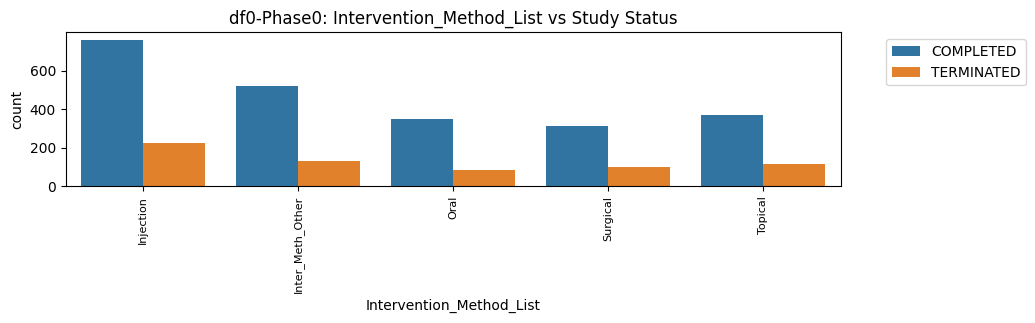

In [51]:
Intervention_Method_List = log_fun("Intervention_Method_List", dfi, i, 'list', False, 90, 'Inter_Meth_Other')

### Intervention_Method_Counts

df0-Phase0:
Intervention_Method_Counts vs Study Status


count    2304.000000
mean        1.289497
std         0.529587
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: Intervention_Method_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:               0.0005037
Time:                        19:08:09   Log-Likelihood:                -1207.2
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                    0.2700
                                 coef    std err          z      P>|z|      [0.025      0.97

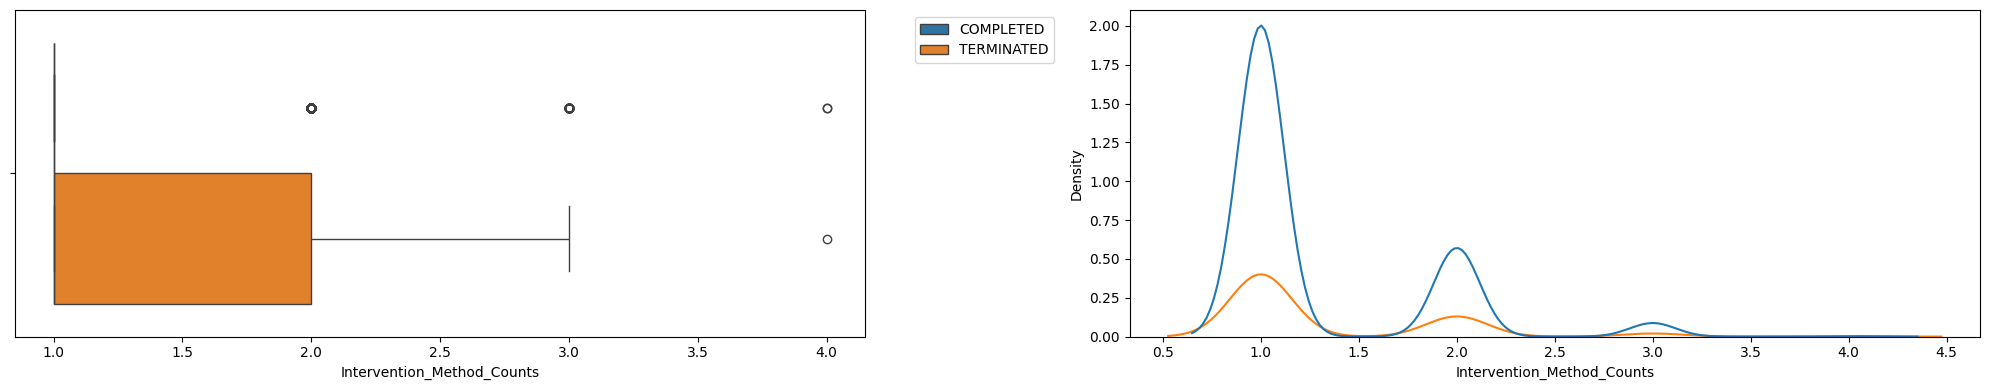

In [52]:
Intervention_Method_Counts = log_fun_cont("Intervention_Method_Counts", dfi, i)

### Intervention_Method_Categ

df0-Phase0:
df0-Phase0: Intervention_Method_Categ vs Study Status


Study Status,COMPLETED,TERMINATED
Intervention_Method_Categ,,
1,1355,365
2–4,447,137


df0-Phase0, Intervention_Method_Categ p-value:
0.282836880750784
No significant difference


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Intervention_Method_Categ vs Study Status


Intervention_Method_Categ,1,2–4
Study Status,,
COMPLETED,1355,447
TERMINATED,365,137


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:               0.0005243
Time:                        19:08:10   Log-Likelihood:                -1207.2
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                    0.2604
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.3117      0.059     22.242      0.000       1.196       1.427
Intervention_Method_Categ    -0.1291      0.114     -1.132      0.258      -0.353     

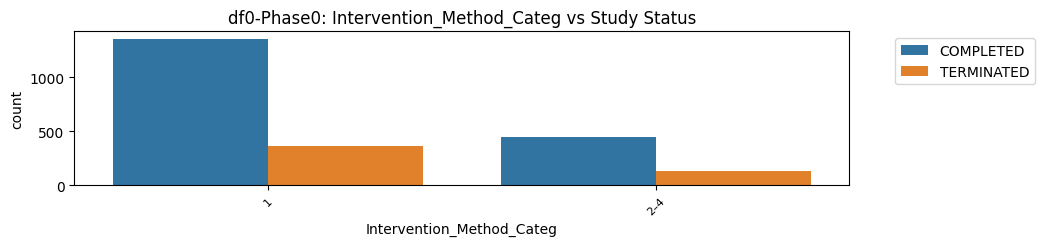

In [53]:
chi2_fun('Intervention_Method_Categ', dfi, i)
#### Log_Fun
Intervention_Method_Categ = log_fun('Intervention_Method_Categ', dfi, i, 'bin', True, 45)

#### AIC

In [54]:
Intervention_Method_Counts_aic = fun_compare(i, Intervention_Method_Counts = Intervention_Method_Counts[0], 
                                             Intervention_Method_Categ = Intervention_Method_Categ[0])

## Locations

### City_Counts

df0-Phase0:
City_Counts vs Study Status


count    2304.000000
mean        1.228299
std         3.785609
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       156.000000
Name: City_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.001072
Time:                        19:08:10   Log-Likelihood:                -1206.5
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                    0.1075
                  coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

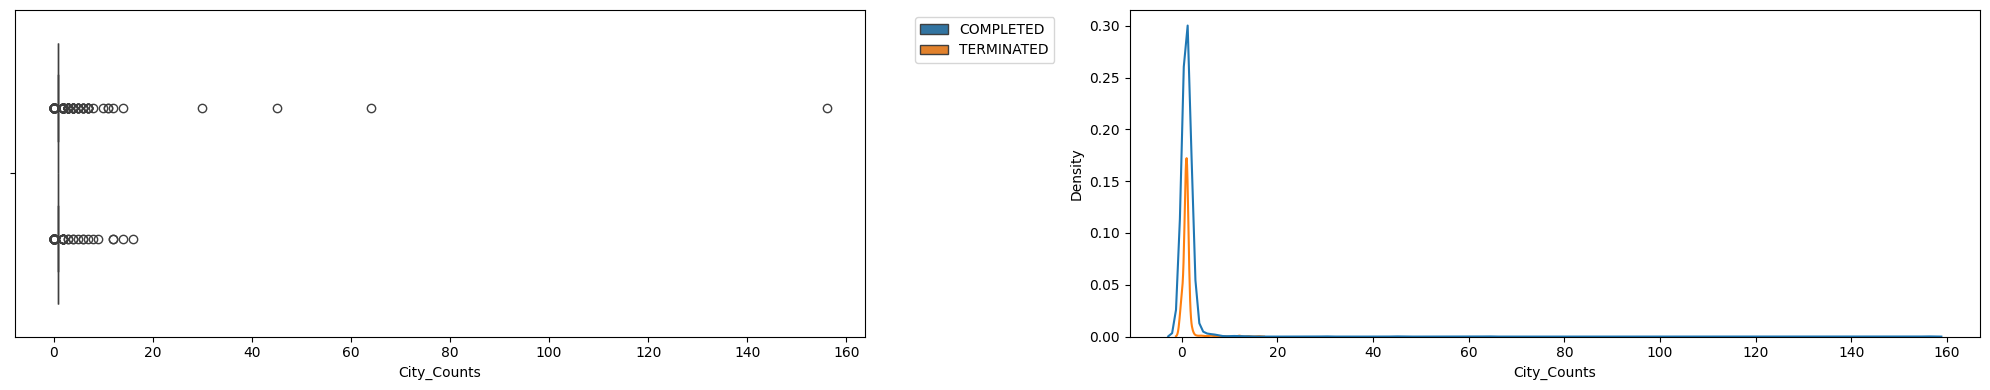

In [55]:
City_Counts = log_fun_cont("City_Counts", dfi, i)

### City_Categ

df0-Phase0:
df0-Phase0: City_Categ vs Study Status


Study Status,COMPLETED,TERMINATED
City_Categ,,
0–1,1679,472
2–156,123,30


df0-Phase0, City_Categ p-value:
0.5654190150552254
No significant difference


------------------------------------------------------------------------------------------------------------

df0-Phase0:
City_Categ vs Study Status


City_Categ,0–1,2–156
Study Status,,
COMPLETED,1679,123
TERMINATED,472,30


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:               0.0001937
Time:                        19:08:11   Log-Likelihood:                -1207.6
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                    0.4939
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2690      0.052     24.357      0.000       1.167       1.371
City_Categ     0.1422      0.210      0.676      0.499      -0.270       0.554


df0-Phase0, City_Categ p-values:
[const         4.

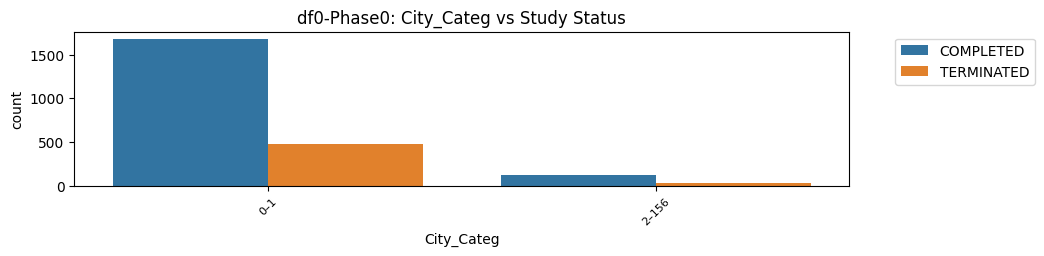

In [56]:
chi2_fun('City_Categ', dfi, i)
#### log_fun
City_Categ = log_fun('City_Categ', dfi, i, 'bin', False, 45)

#### AIC

In [57]:
City_Counts_aic = fun_compare(i, City_Counts = City_Counts[0], City_Categ = City_Categ[0])

### Country_Counts


df0-Phase0:
Country_Counts vs Study Status


count    2304.000000
mean        0.977865
std         0.439017
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        10.000000
Name: Country_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.002314
Time:                        19:08:11   Log-Likelihood:                -1205.0
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                   0.01806
                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

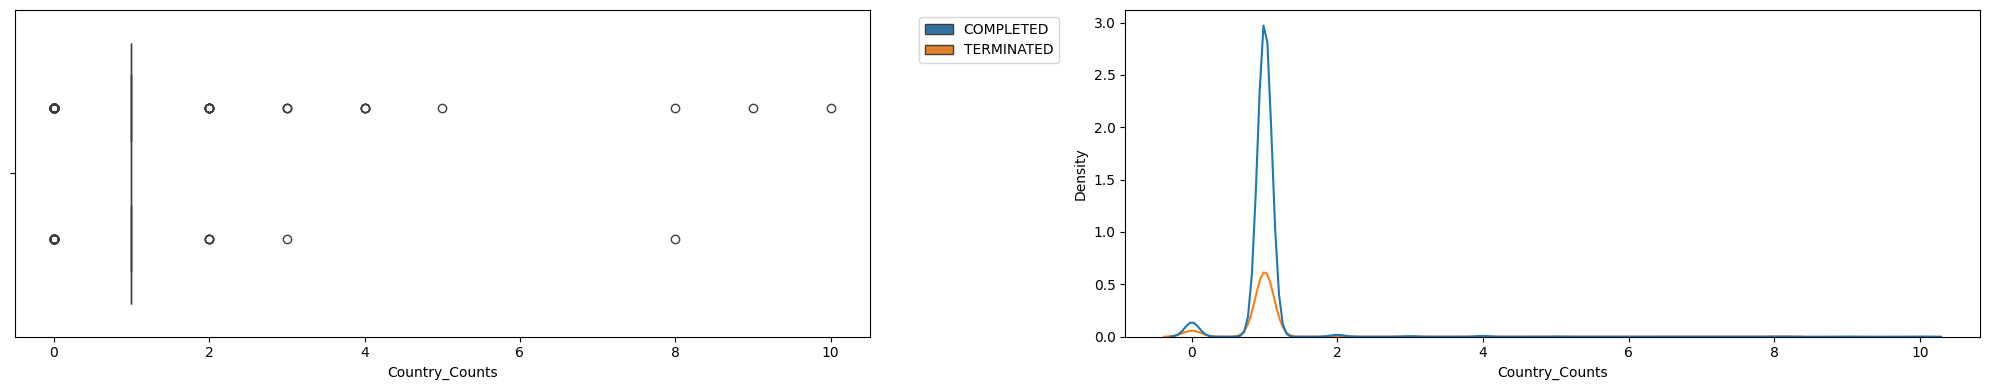

In [58]:
Country_Counts = log_fun_cont("Country_Counts", dfi, i)

### Country_Categ

df0-Phase0:
df0-Phase0: Country_Categ vs Study Status


Study Status,COMPLETED,TERMINATED
Country_Categ,,
0–1,1781,496
2–10,21,6


df0-Phase0, Country_Categ p-value:
1.0
No significant difference


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Country_Categ vs Study Status


Country_Categ,0–1,2–10
Study Status,,
COMPLETED,1781,21
TERMINATED,496,6


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:               1.244e-06
Time:                        19:08:12   Log-Likelihood:                -1207.8
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                    0.9563
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.2784      0.051     25.179      0.000       1.179       1.378
Country_Categ    -0.0257      0.466     -0.055      0.956      -0.938       0.887


df0-Phase0, Country_Categ p-values:
[c

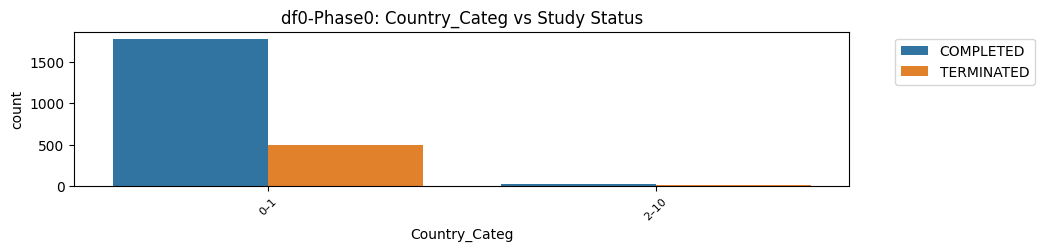

In [59]:
chi2_fun('Country_Categ', dfi, i)
#### log_fun
Country_Categ = log_fun('Country_Categ', dfi, i, 'bin', True, 45)

#### AIC

In [60]:
Country_Counts_aic = fun_compare(i, Country_Counts = Country_Counts[0], Country_Categ = Country_Categ[0])

### Continents_List 

df0-Phase0:
Continents_List vs Study Status


Continents_List,Africa,Asia,Cont_None,Europe,North America,Oceania,South America
Study Status,,,,,,,
COMPLETED,97,192,98,242,1151,13,20
TERMINATED,2,17,43,33,404,5,3


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2297
Method:                           MLE   Df Model:                            6
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.04151
Time:                        19:08:12   Log-Likelihood:                -1157.7
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                 2.204e-19
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9565      0.184      5.201      0.000       0.596       1.317
Africa            2.9175      0.738      3.956      0.000       1.472       4.363
Asia              1.4541      0.310     

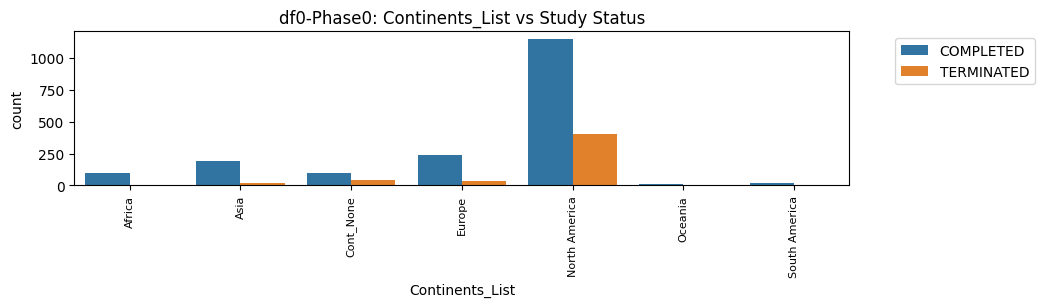

In [61]:
Continents_List = log_fun("Continents_List", dfi, i, 'list', False, 90, 'Cont_None')

### Continent_Counts

df0-Phase0:
Continent_Counts vs Study Status


count    2304.000000
mean        0.945747
std         0.260447
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Continent_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.001738
Time:                        19:08:12   Log-Likelihood:                -1205.7
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                   0.04045
                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

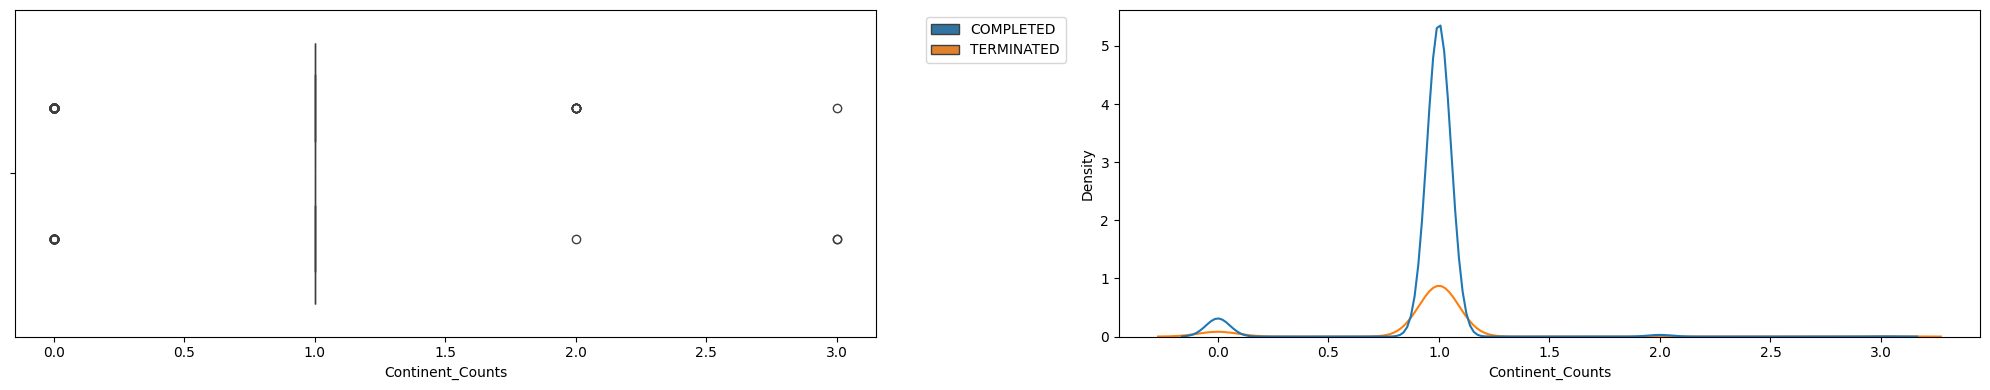

In [62]:
Continent_Counts = log_fun_cont("Continent_Counts", dfi, i)

### Continent_Categ

df0-Phase0:
df0-Phase0: Continent_Categ vs Study Status


Study Status,COMPLETED,TERMINATED
Continent_Categ,,
0–1,1792,499
2–3,10,3


df0-Phase0, Continent_Categ p-value:
1.0
No significant difference


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Continent_Categ vs Study Status


Continent_Categ,0–1,2–3
Study Status,,
COMPLETED,1792,10
TERMINATED,499,3


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:               5.201e-06
Time:                        19:08:13   Log-Likelihood:                -1207.8
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                    0.9108
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2785      0.051     25.259      0.000       1.179       1.378
Continent_Categ    -0.0755      0.660     -0.114      0.909      -1.369       1.218


df0-Phase0, Continent_Categ p-

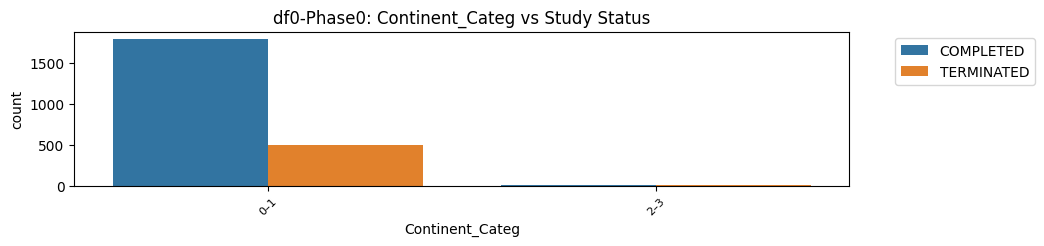

In [63]:
chi2_fun('Continent_Categ', dfi, i)
#### log_fun
Continent_Categ = log_fun('Continent_Categ', dfi, i, 'bin', True, 45)

#### AIC

In [64]:
Continent_Counts_aic = fun_compare(i, Continent_Counts = Continent_Counts[0], Continent_Categ = Continent_Categ[0])

#### AIC_all

In [65]:
Locations_aic = fun_compare(i, City_Counts = City_Counts[0], 
                            Country_Counts = Country_Counts[0], 
                            Continent_Counts = Continent_Counts[0])

## Datetimes

### Start_Date_Year_Counts

df0-Phase0:
Start_Date_Year_Counts vs Study Status


count         2304.0
mean     2017.223524
std         3.436028
min           2011.0
25%           2014.0
50%           2017.5
75%           2020.0
max           2024.0
Name: Start_Date_Year_Counts, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.002868
Time:                        19:08:13   Log-Likelihood:                -1204.3
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                  0.008486
                             coef    std err          z      P>|z|      [0.025      0.975]
---------

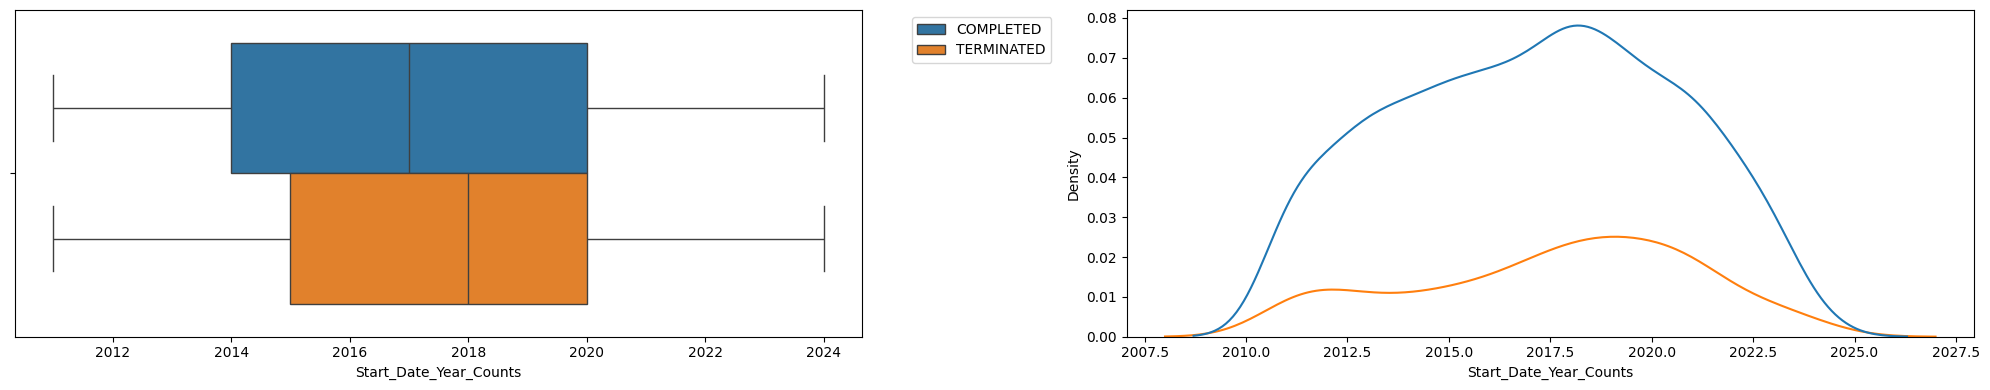

In [66]:
Start_Date_Year_Counts = log_fun_cont("Start_Date_Year_Counts", dfi, i)

### Start_Date_Year_Categ

df0-Phase0:
df0-Phase0: Start_Date_Year_Categ vs Study Status


Study Status,COMPLETED,TERMINATED
Start_Date_Year_Categ,,
2011-2018,1126,274
2019-2024,676,228


df0-Phase0, Start_Date_Year_Categ p-value:
0.0015993608430351876
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Start_Date_Year_Categ vs Study Status


Start_Date_Year_Categ,2011-2018,2019-2024
Study Status,,
COMPLETED,1126,676
TERMINATED,274,228


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.004213
Time:                        19:08:14   Log-Likelihood:                -1202.7
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                  0.001423
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.4133      0.067     20.981      0.000       1.281       1.545
Start_Date_Year_Categ    -0.3265      0.102     -3.201      0.001      -0.526      -0.127


df0-Ph

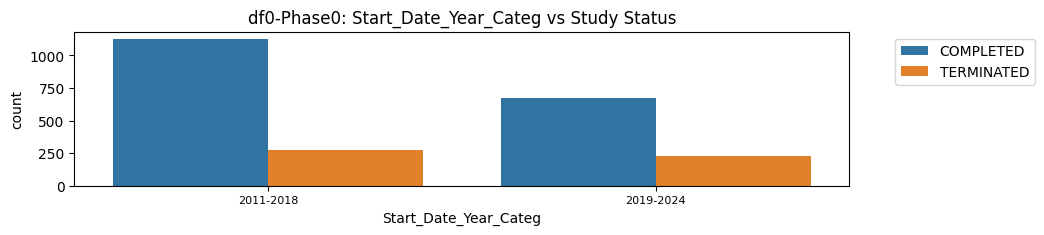

In [67]:
chi2_fun("Start_Date_Year_Categ", dfi, i)
#### log_fun
Start_Date_Year_Categ = log_fun("Start_Date_Year_Categ", dfi, i, 'bin', True, 0)

#### AIC 

In [68]:
# Start_Date_Year_Counts = Start_Date_Year_Counts[0] --> wont be used as year is about to look for post vs past covid patterns.
Start_Date_Year_Counts_aic = fun_compare(i, Start_Date_Year_Categ = Start_Date_Year_Categ[0])

### Completion_Date_Year 
- will not run AIC --> Date - Year itself is not a feature affecting the outcome.


df0-Phase0:
Completion_Date_Year_Counts vs Study Status


count         2304.0
mean     2019.257812
std         3.366256
min           2011.0
25%           2017.0
50%           2020.0
75%           2022.0
max           2024.0
Name: Completion_Date_Year_Counts, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.003392
Time:                        19:08:14   Log-Likelihood:                -1203.7
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                  0.004205
                                  coef    std err          z      P>|z|      [0.025      0

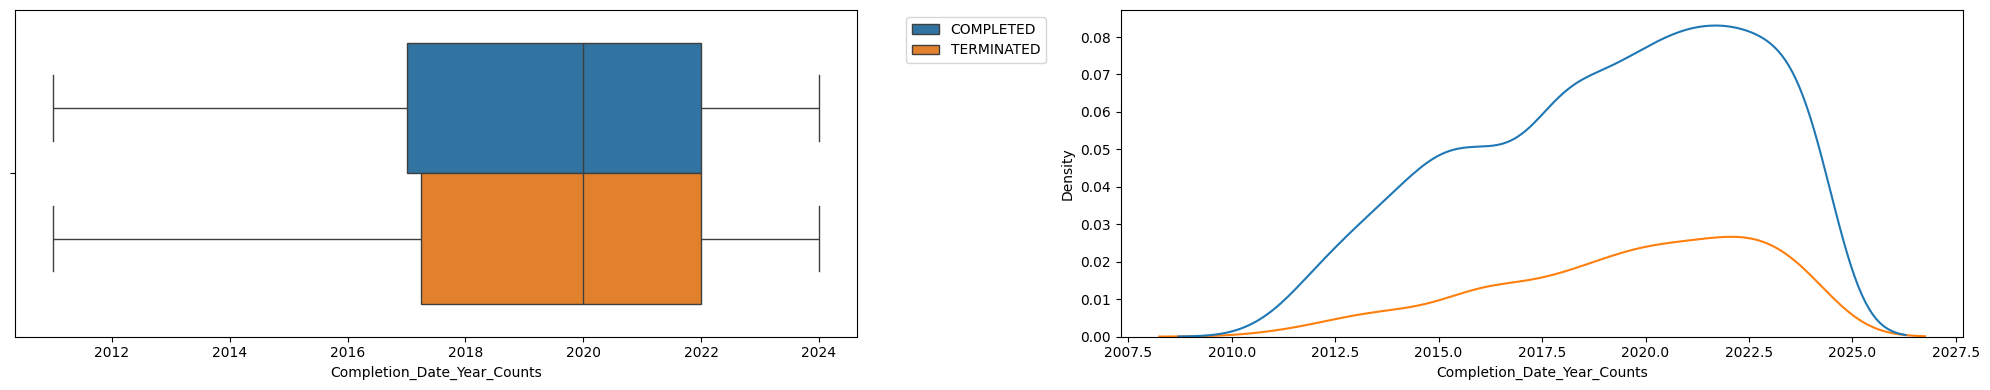

In [69]:
Completion_Date_Year_Counts = log_fun_cont("Completion_Date_Year_Counts", dfi, i)

### Completion_Date_Year_Categ

df0-Phase0:
df0-Phase0: Completion_Date_Year_Categ vs Study Status


Study Status,COMPLETED,TERMINATED
Completion_Date_Year_Categ,,
2011-2018,721,165
2019-2024,1081,337


df0-Phase0, Completion_Date_Year_Categ p-value:
0.0042725085602064615
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Completion_Date_Year_Categ vs Study Status


Completion_Date_Year_Categ,2011-2018,2019-2024
Study Status,,
COMPLETED,721,1081
TERMINATED,165,337


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.003558
Time:                        19:08:15   Log-Likelihood:                -1203.5
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                  0.003373
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.4747      0.086     17.088      0.000       1.306       1.644
Completion_Date_Year_Categ    -0.3091      0.106     -2.903      0.004      -0.518 

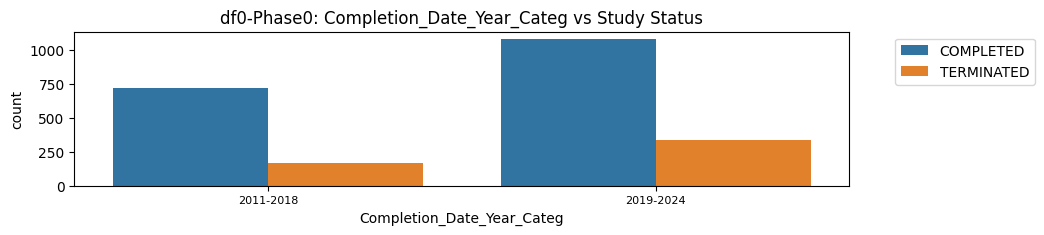

In [70]:
chi2_fun("Completion_Date_Year_Categ", dfi, i)
### log_fun
Completion_Date_Year_Categ = log_fun("Completion_Date_Year_Categ", dfi, i, 'bin', True, 0)

#### AIC

In [71]:
# Completion_Date_Year_Counts = Completion_Date_Year_Counts[0] --> wont be used as year is about to look for post vs past covid patterns.
Completion_Date_Year_Counts_aic = fun_compare(i, Completion_Date_Year_Categ = Completion_Date_Year_Categ[0])

#### AIC_all

In [72]:
Date_Year_aic = fun_compare(i, Start_Date_Year_Categ = Start_Date_Year_Categ[0],
                            Completion_Date_Year_Categ = Completion_Date_Year_Categ[0])

### Completion_Gap_Counts

- Notice Termination main Distribution median = Around 20 participants --> cutpoint

df0-Phase0:
Completion_Gap_Counts vs Study Status


count       2304.0
mean     24.924913
std      20.113227
min            0.0
25%           10.0
50%           20.0
75%           35.0
max          128.0
Name: Completion_Gap_Counts, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:               2.957e-06
Time:                        19:08:15   Log-Likelihood:                -1207.8
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                    0.9326
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

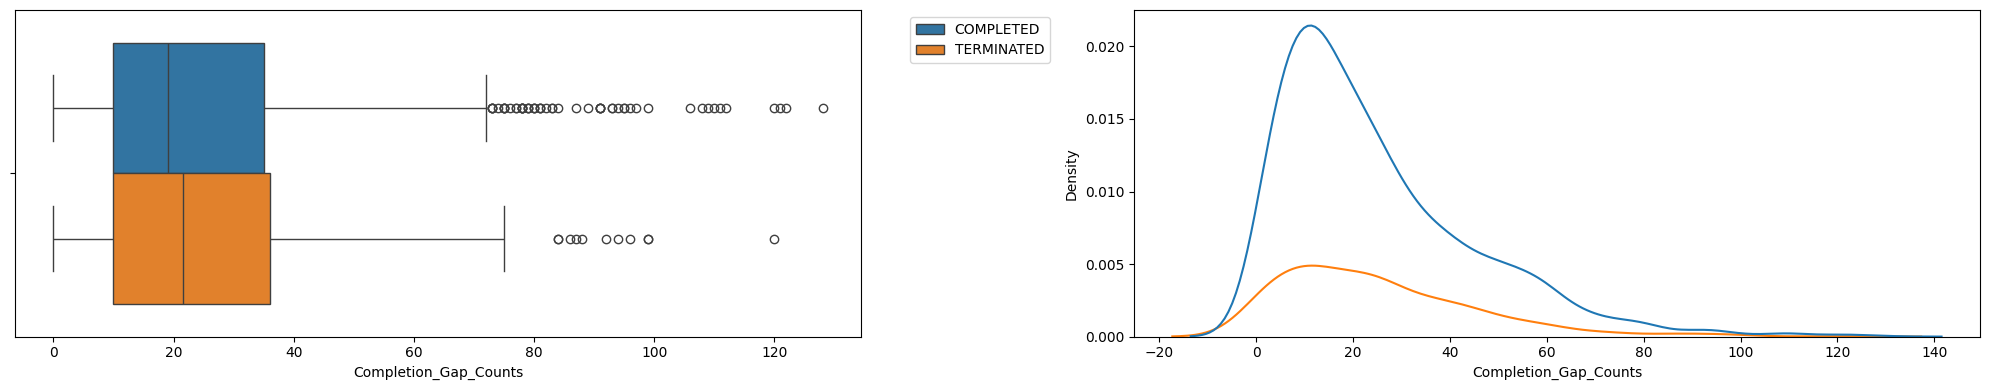

In [73]:
Completion_Gap_Counts = log_fun_cont("Completion_Gap_Counts", dfi, i)

### Completion_Gap_Categ

df0-Phase0:
df0-Phase0: Completion_Gap_Categ vs Study Status


Study Status,COMPLETED,TERMINATED
Completion_Gap_Categ,,
0–20,943,241
21–128,859,261


df0-Phase0, Completion_Gap_Categ p-value:
0.09625913976990083
No significant difference


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Completion_Gap_Categ vs Study Status


Completion_Gap_Categ,0–20,21–128
Study Status,,
COMPLETED,943,859
TERMINATED,241,261


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                0.001215
Time:                        19:08:16   Log-Likelihood:                -1206.3
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                   0.08662
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.3643      0.072     18.901      0.000       1.223       1.506
Completion_Gap_Categ    -0.1730      0.101     -1.713      0.087      -0.371       0.025


df0-Phase0

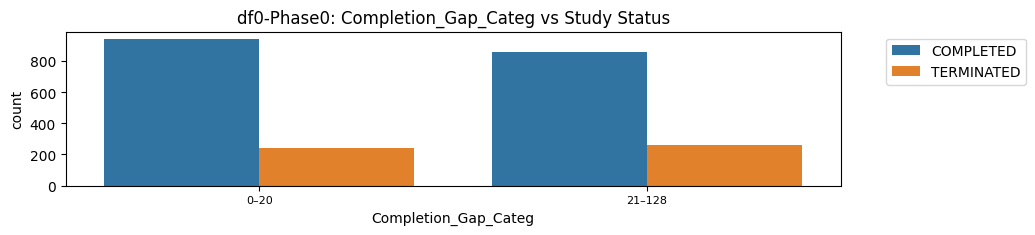

In [74]:
chi2_fun('Completion_Gap_Categ', dfi, i)
#### log_fun
Completion_Gap_Categ = log_fun('Completion_Gap_Categ', dfi, i, 'bin', True, 0)

#### AIC 

In [75]:
Completion_Gap_Counts_aic = fun_compare(i, Completion_Gap_Counts = Completion_Gap_Counts[0], Completion_Gap_Categ = Completion_Gap_Categ[0])

## Enrollment

### Enrollment_Counts

df0-Phase0:
Enrollment_Counts vs Study Status


count    2304.000000
mean       49.031250
std       207.342017
min         0.000000
25%         7.000000
50%        20.000000
75%        43.000000
max      5998.000000
Name: Enrollment_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                 0.04855
Time:                        19:08:16   Log-Likelihood:                -1149.2
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                 2.498e-27
                        coef    std err          z      P>|z|      [0.025      0.975]
------------------------

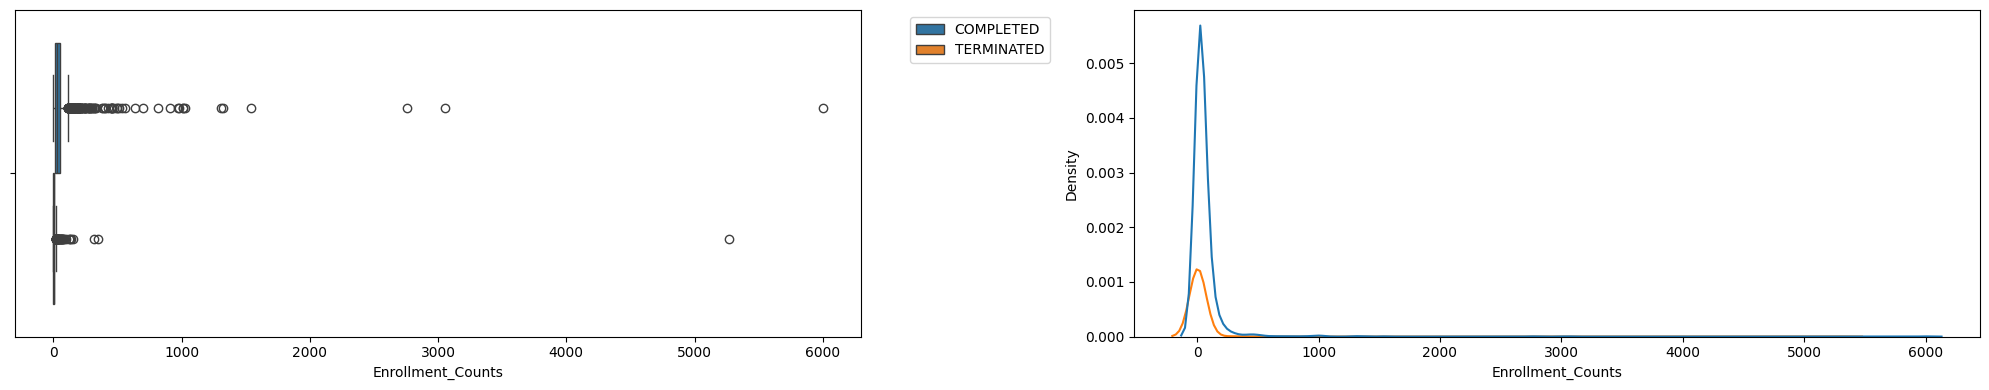

In [76]:
Enrollment_Counts = log_fun_cont("Enrollment_Counts", dfi, i)

### Enrollment_Counts_Log

df0-Phase0:
Enrollment_Counts_Log vs Study Status


count    2304.000000
mean        2.852974
std         1.430698
min         0.000000
25%         2.079442
50%         3.044522
75%         3.784190
max         8.699348
Name: Enrollment_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                  0.4296
Time:                        19:08:17   Log-Likelihood:                -688.87
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                1.069e-227
                            coef    std err          z      P>|z|      [0.025      0.975]
------------

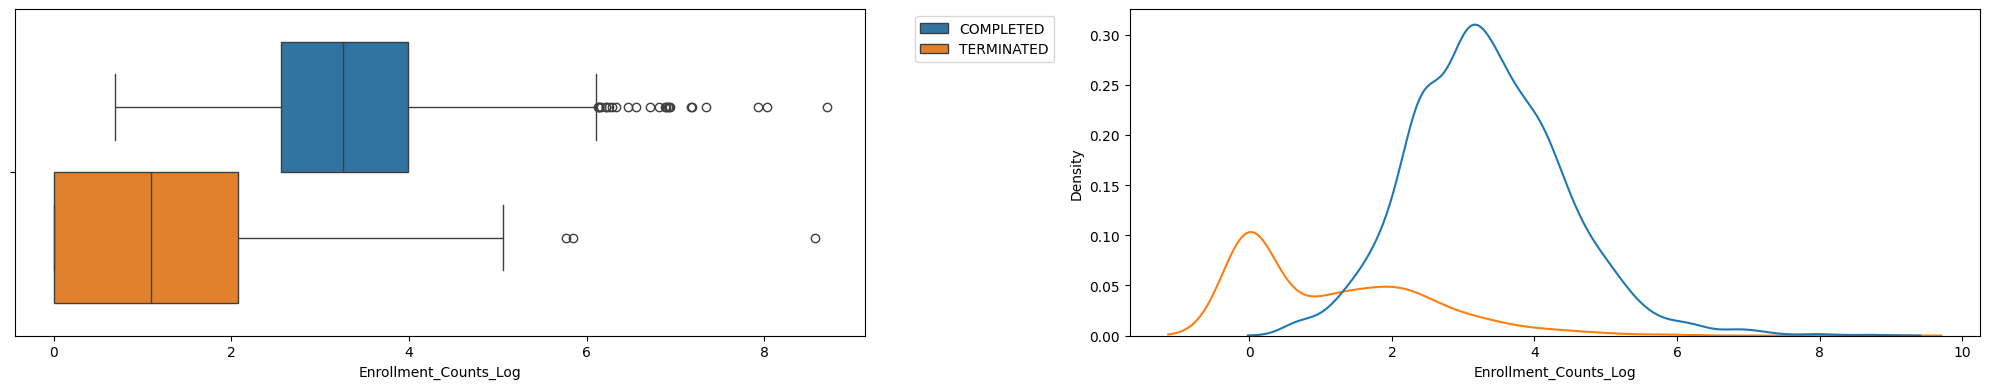

In [77]:
Enrollment_Counts_Log = log_fun_cont("Enrollment_Counts_Log", dfi, i)

### Enrollement_Sqrt

df0-Phase0:
Enrollment_Counts_Sqrt vs Study Status


count    2304.000000
mean        5.134247
std         4.762416
min         0.000000
25%         2.645751
50%         4.472136
75%         6.557439
max        77.446756
Name: Enrollment_Counts_Sqrt, dtype: float64


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                  0.3361
Time:                        19:08:17   Log-Likelihood:                -801.86
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                1.422e-178
                             coef    std err          z      P>|z|      [0.025      0.975]
---------

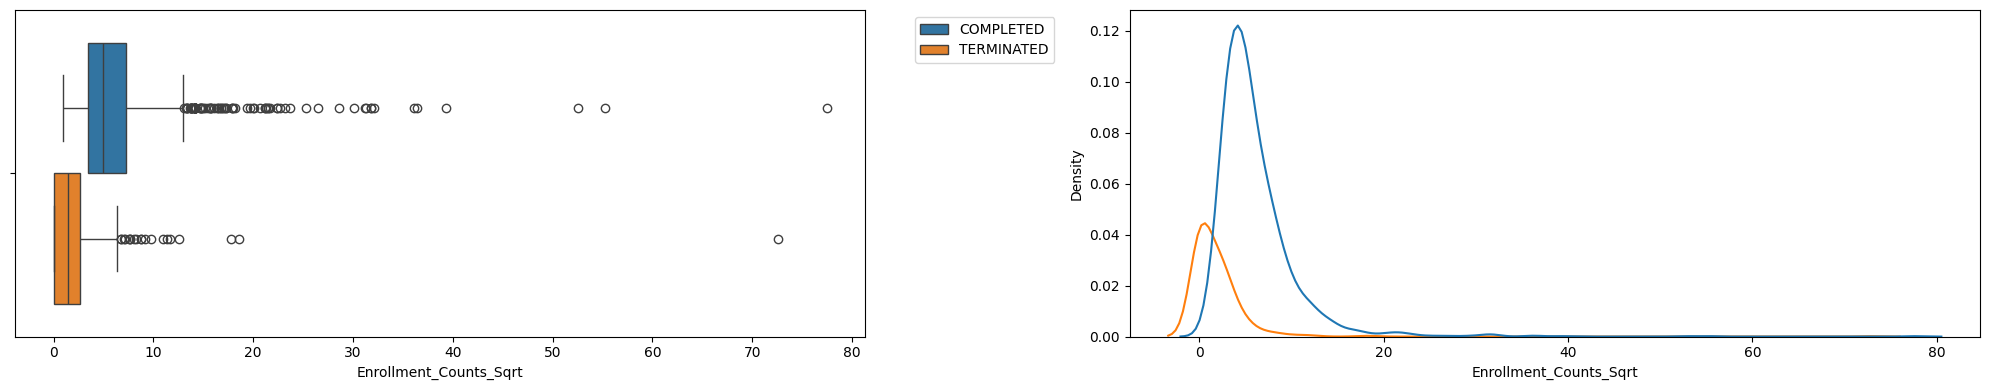

In [78]:
Enrollment_Counts_Sqrt = log_fun_cont("Enrollment_Counts_Sqrt", dfi, i)

### Enrollment_Categ
- See Enrollment Plot as Continues below. Better Plot as continues (BoxPlot)

df0-Phase0:
df0-Phase0: Enrollment_Categ vs Study Status


Study Status,COMPLETED,TERMINATED
Enrollment_Categ,,
0–20,783,458
21–5998,1019,44


df0-Phase0, Enrollment_Categ p-value:
5.099790557894436e-80
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df0-Phase0:
Enrollment_Categ vs Study Status


Enrollment_Categ,0–20,21–5998
Study Status,,
COMPLETED,783,1019
TERMINATED,458,44


                           Logit Regression Results                           
Dep. Variable:           Study Status   No. Observations:                 2304
Model:                          Logit   Df Residuals:                     2302
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                  0.1718
Time:                        19:08:18   Log-Likelihood:                -1000.3
converged:                       True   LL-Null:                       -1207.8
Covariance Type:            nonrobust   LLR p-value:                 3.148e-92
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5363      0.059      9.116      0.000       0.421       0.652
Enrollment_Categ     2.6060      0.165     15.811      0.000       2.283       2.929


df0-Phase0, Enrollment_Cat

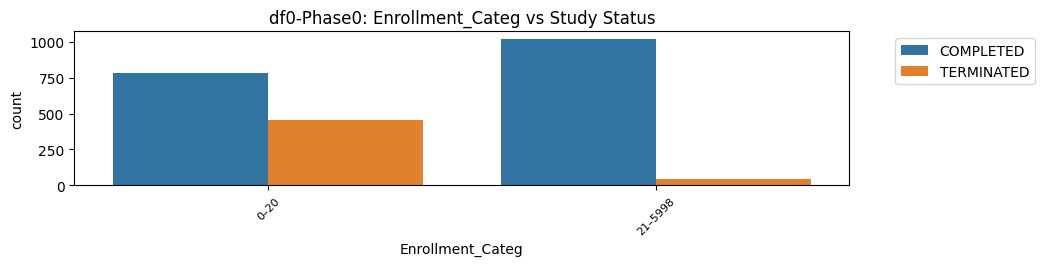

In [79]:
chi2_fun("Enrollment_Categ", dfi, i)
#### log_fun
Enrollment_Categ = log_fun('Enrollment_Categ', dfi, i, 'bin', True, 45)

#### AIC

In [80]:
Enrollemnt_Counts_aic = fun_compare(i, Enrollment_Counts = Enrollment_Counts[0], 
                                    Enrollment_Counts_Log = Enrollment_Counts_Log[0], 
                                    Enrollment_Counts_Sqrt = Enrollment_Counts_Sqrt[0], 
                                    Enrollment_Categ = Enrollment_Categ[0])

# AICS

## AIC_all

In [81]:
aic_all = [Conditions_aic,
        Adverse_aic,
        Masking_aic,  
        Locations_aic,
        Date_Year_aic,
]


## AIC_Total

In [82]:
aics = [Adverse_Counts_aic, Adverse_System_Counts_aic, 
        Arm_Counts_aic,
        Intervention_Type_Counts_aic, Intervention_Method_Counts_aic,
        City_Counts_aic, Country_Counts_aic, Continent_Counts_aic, 
        Completion_Gap_Counts_aic, Start_Date_Year_Counts_aic, Completion_Date_Year_Counts_aic,
        Enrollemnt_Counts_aic]

for idx in range(len(aics)):
    aic = aics[idx]
    for col in aic.columns:
        if '_' in col:
            new_col = col.split('_')[-1]
            aic.rename(columns = {col: new_col}, inplace = True)
    aics[idx] = aic
# aics[-2] # Example

AIC_Total = pd.concat(aics, ignore_index = False)
AIC_Total = AIC_Total.rename(columns = {'min' : 'AIC_Min'})
AIC_Total = AIC_Total.reindex(labels = ['Counts', 'Log', 'Sqrt', 'Categ', 'Bin', 'AIC_Min'], axis = 1)
AIC_Total

,Counts,Log,Sqrt,Categ,Bin,AIC_Min
df0,,,,,,
Adverse_Counts,[2412.0],[2409.0],[2409.0],[2413.0],[2413.0],Adverse_Counts_Log
Adverse_System_Counts,[2419.0],[2416.0],[2416.0],[2417.0],NaN,Adverse_System_Counts_Log
Arm_Counts,[2350.0],NaN,NaN,[2370.0],NaN,Arm_Counts
Intervention_Type_Counts,[2410.0],NaN,NaN,[2406.0],NaN,Intervention_Type_Categ
Intervention_Method_Counts,[2418.0],NaN,NaN,[2418.0],NaN,Intervention_Method_Counts
City_Counts,[2417.0],NaN,NaN,[2419.0],NaN,City_Counts
Country_Counts,[2414.0],NaN,NaN,[2420.0],NaN,Country_Counts
Continent_Counts,[2415.0],NaN,NaN,[2420.0],NaN,Continent_Counts
Completion_Gap_Counts,[2420.0],NaN,NaN,[2417.0],NaN,Completion_Gap_Categ


# Drop cols
Drop cols that are not going to be used in analysis.

In [83]:
for dfi in dfis:
    dfi.drop(columns = [
# unique identifiers of trials, not status associated.
        "Study Title", "official_title", "Other IDs", "Acronym", "Study URL", 'Brief Summary', "nct_id", 
# used through as other columns
        "Study Type", "Study Design", "Interventions", 'Conditions', 
 # Actual Dates trials happened is not reason for status.
        "Start Date", "Completion Date", "Primary Completion Date",
        "First Posted", "Results First Posted", "Last Update Posted",       
# used merged in another column
        'Sponsor', 'Collaborators', 'Sponsor_Type', 'Collaborator_Type', 
# text data/many categorize --> used continents/country counts insted.
        "Countries_List", "Locations", 
# 145k trials with non uploaded Documents --> not logical sample        
        "Study Documents", 'Study_Documents_List', 'Document_Counts', 'Document_Bin',
 # Outcomes are a Study result not a pre - Designed characteristic
        "Study Results",
        'Primary Outcome Measures', 'Secondary Outcome Measures', 'Other Outcome Measures',
        'Outcomes_List', 'Outcomes_Counts', 'Outcomes_Bin',
        'Injection', 'Oral', 'Topical','Surgical',       

        ] , axis = 1, inplace = True)

Keep cols based on their AIC scores etc.

In [84]:
keep_cols = AIC_Total['AIC_Min'].tolist()
keys = ['_dum', '_list', '_bin']
keep_cols1 = [col for col in dfi.columns if any(k in col.lower() for k in keys)]

keep_cols = keep_cols + keep_cols1 + ['Study Status']

dfi = dfi[keep_cols]
dfi.columns
keep_cols

['Adverse_Counts_Log',
 'Adverse_System_Counts_Log',
 'Arm_Counts',
 'Intervention_Type_Categ',
 'Intervention_Method_Counts',
 'City_Counts',
 'Country_Counts',
 'Continent_Counts',
 'Completion_Gap_Categ',
 'Start_Date_Year_Categ',
 'Completion_Date_Year_Categ',
 'Enrollment_Counts_Log',
 'Sex_Dum',
 'Age_List',
 'Funder_Type_Dum',
 'Sponsor_Collab_List',
 'Intervention_Type_List',
 'Intervention_Method_List',
 'Placebo_Bin',
 'Standard_Care_Bin',
 'Healthy_Bin',
 'Covid_19_Bin',
 'Conditions_List',
 'Conditions_Spec_List',
 'Adverse_List',
 'Adverse_Bin',
 'Adverse_System_List',
 'Allocation_Dum',
 'Intervention_Model_Dum',
 'Masking_Dum',
 'Masking_Detail_List',
 'Primary_Purpose_Dum',
 'Continents_List',
 'Study Status']

# P_Value/ CL : Univariable 

In [85]:
# cls df
cl_vars = keep_cols.copy()
cl_list = [globals()[var][2][1:] for var in cl_vars if var!= 'Study Status']  
cls = pd.concat(cl_list, axis = 0).reset_index(drop = False)
cls = cls.rename(columns = {'index': 'Variable', 0: 'Lower_CL', 1: 'Upper_CL'})
cls[['Lower_CL', 'Upper_CL']] = cls[['Lower_CL', 'Upper_CL']].round(3)

# p_values df
p_vars = keep_cols.copy()
p_list = [globals()[var][1][0][1:] for var in p_vars if var!= 'Study Status']   
# [1][0][1:] Explain:
# [1] --> index = 1 of function's returns = p_value , 
# [0] --> gives back the unique element of list as a df, 
# [1:] --> excludes 1st row which is the constant.
p_values = pd.concat(p_list, axis = 0).reset_index(drop = False)
p_values = p_values.rename(columns = {'index': 'Variable', 0: 'p-value'})
p_values['p-value'] = p_values['p-value'].round(3)

# p_cl df
p_cl = pd.merge(left = p_values, right = cls, how = 'inner', on = 'Variable')
p_cl['Stat_Sig'] = np.where(
    (((cls['Lower_CL'] < 0.0) & (cls['Upper_CL'] < 0.0)) | ((cls['Lower_CL'] > 0.0) & (cls['Upper_CL'] > 0.0))) & 
     (p_cl['p-value'] < 0.05), 
     'Stat_Sig', '-'
)
p_cl.index.name = f'df{i}'
p_cl = p_cl.sort_values(by = 'Variable')
p_cl

,Variable,p-value,Lower_CL,Upper_CL,Stat_Sig
df0,,,,,
14,ADULT,0.757,-0.421,0.578,-
66,Adv_Death,0.969,-0.659,0.686,-
67,Adv_Other,0.186,-0.156,0.805,-
68,Adv_Serious,0.443,-0.498,1.138,-
70,Adv_Sy_Blood/ Lymphatic,0.395,-2.038,0.804,-
...,...,...,...,...,...
34,Topical,0.127,-0.431,0.054,-
20,University,0.898,-0.203,0.231,-
63,"Urogenital, Pregnancy",0.907,-0.334,0.376,-


# Save

## Save AIC_All

In [ ]:
def save_aic_all(i):
    if i == '':
        path = r".\aics\aic_all_vizual.pkl"
    elif i == 0:
        path = r".\aics\aic0_all_vizual.pkl"
    elif i == 1:
        path = r".\aics\aic1_all_vizual.pkl"
    elif i == 2:
        path = r".\aics\aic2_all_vizual.pkl"
    elif i == 3:
        path = r".\aics\aic3_all_vizual.pkl"
    elif i == 4:
        path = r".\aics\aic4_all_vizual.pkl"
    elif i == 5:
        path = r".\aics\aic5_all_vizual.pkl"           
        
    return path
    
with open(save_aic_all(aic_all, i), 'wb') as f:  # with cause it is a list of dfs.
    pickle.dump(aic_all, f)


## Save AIC_Total

In [ ]:
def save_aic_total(aic_total, i):
    if i == '':
        path = r".\aics\aic_vizual.pkl"
    elif i == 0:
        path = r".\aics\aic0_vizual.pkl"
    elif i == 1:
        path = r".\aics\aic1_vizual.pkl"
    elif i == 2:
        path = r".\aics\aic2_vizual.pkl"
    elif i == 3:
        path = r".\aics\aic3_vizual.pkl"
    elif i == 4:
        path = r".\aics\aic4_vizual.pkl"
    elif i == 5:
        path = r".\aics\aic5_vizual.pkl"

    return aic_total.to_pickle(path)

save_aic_total(AIC_Total, i)

## Save p_values

In [88]:
def save_pvalue_pickle(p_cl, i):
    if i == '':
        path = r".\p_values\p_cl_vizual.pkl"
    elif i == 0:
        path = r".\p_values\p_cl0_vizual.pkl"
    elif i == 1:
        path = r".\p_values\p_cl1_vizual.pkl"
    elif i == 2:
        path = r".\p_values\p_cl2_vizual.pkl"
    elif i == 3:
        path = r".\p_values\p_cl3_vizual.pkl"
    elif i == 4:
        path = r".\p_values\p_cl4_vizual.pkl"
    elif i == 5:
        path = r".\p_values\p_cl5_vizual.pkl"

    return p_cl.to_pickle(path)

save_pvalue_pickle(p_cl, i)


## Save Dfis
- Changes applied in drop columns

In [89]:
def save_df_pickle(dfi, i):
    if i == '':
        path = r".\df_vizual\df_vizual.pkl"
    elif i == 0:
        path = r".\df_vizual\df0_vizual.pkl"
    elif i == 1:
        path = r".\df_vizual\df1_vizual.pkl"
    elif i == 2:
        path = r".\df_vizual\df2_vizual.pkl"
    elif i == 3:
        path = r".\df_vizual\df3_vizual.pkl"
    elif i == 4:
        path = r".\df_vizual\df4_vizual.pkl"
    elif i == 5:
        path = r".\df_vizual\df5_vizual.pkl"

    return dfi.to_pickle(path)

save_df_pickle(dfi, i)